In [3]:
import labMTsimple.storyLab
from tqdm import trange
import pandas as pd
import codecs
import re
import seaborn as sns
from numpy import floor,zeros,array
import numpy as np
import shutil
import subprocess
import datetime

In [2]:
lexicon = pd.read_csv('./NRC-VAD-Lexicon-Aug2018Release/NRC-VAD-Lexicon-Aug2018Release/NRC-VAD-Lexicon.txt', sep='\t')

In [3]:
lexicon['Ranking'] = np.arange(1, len(lexicon)+1)

In [4]:
columnsTitles = ["Word","Ranking","Arousal","Valence","Dominance"]
lexicon = lexicon.reindex(columns=columnsTitles)

In [5]:
avd_dict = lexicon.set_index('Word').T.to_dict('list')

In [6]:
nlist = lexicon['Arousal'].tolist()

In [7]:
wlist = lexicon['Word'].tolist()

In [8]:
labMT = avd_dict
labMTvector = nlist
labMTwordList = wlist

In [9]:
def chopper(words,labMT,labMTvector,outfile,minSize=1000):
  # print "now splitting the text into chunks of size 1000"
  # print "and printing those frequency vectors"
  allFvec = []
  from numpy import floor
  for i in range(int(floor(len(words)/minSize))):
    chunk = str('')
    if i == int(floor(len(words)/minSize))-1:
      # take the rest
      # print 'last chunk'
      # print 'getting words ' + str(i*minSize) + ' through ' + str(len(words)-1)
      for j in range(i*minSize,len(words)-1):
        chunk += words[j]+str(' ')
    else:
      # print 'getting words ' + str(i*minSize) + ' through ' + str((i+1)*minSize)
      for j in range(i*minSize,(i+1)*minSize):
        chunk += words[j]+str(' ')
        # print chunk[0:10]
    textValence,textFvec = labMTsimple.storyLab.emotion(chunk,labMT,shift=True,happsList=labMTvector)
      # print chunk
    # print 'the valence of {0} part {1} is {2}'.format(rawbook,i,textValence)
        
    allFvec.append(textFvec)


  f = open(outfile,"w")
  if len(allFvec) > 0:
    print("writing out the file to {0}".format(outfile))
    f.write('{0:.0f}'.format(allFvec[0][0]))
    for k in range(1,len(allFvec)):
      f.write(',{0:.0f}'.format(allFvec[k][0]))
    for i in range(1,len(allFvec[0])):
      f.write("\n")
      f.write('{0:.0f}'.format(allFvec[0][i]))
      for k in range(1,len(allFvec)):
        f.write(',{0:.0f}'.format(allFvec[k][i]))
    f.close()
  else:
    print("\""*40)
    print("could not write to {0}".format(outfile))
    print("\""*40)
  # print "done!"

In [10]:
def precomputeTimeseries(fullVec,labMT,labMTvector,outfile):
  minWindows = 10
  timeseries = [0 for i in range(len(fullVec[0])+1)]
  # print len(timeseries)

  textFvec = [0 for j in range(len(fullVec))]
  for i in range(0,minWindows//2):
    textFvec = [textFvec[j]+fullVec[j][i] for j in range(len(fullVec))]
    # print "adding point {0}".format(i)

  for i in range(minWindows//2,minWindows):
    # print "scoring"
    stoppedVec = labMTsimple.storyLab.stopper(textFvec,labMTvector,labMTwordList,stopVal=2.0)
    timeseries[i-minWindows//2] = labMTsimple.storyLab.emotionV(stoppedVec,labMTvector)
    # print "adding point {0}".format(i)
    textFvec = [textFvec[j]+fullVec[j][i] for j in range(len(fullVec))]

  for i in range(minWindows,len(timeseries)-1):
    # print "scoring"
    stoppedVec = labMTsimple.storyLab.stopper(textFvec,labMTvector,labMTwordList,stopVal=2.0)
    timeseries[i-minWindows//2] = labMTsimple.storyLab.emotionV(stoppedVec,labMTvector)
    # print "adding point {0}".format(i)
    # print "removing point {0}".format(i-minWindows)
    textFvec = [textFvec[j]+fullVec[j][i]-fullVec[j][i-minWindows] for j in range(len(fullVec))]

  for i in range(len(timeseries)-1,len(timeseries)+minWindows//2):
    # print "scoring"
    stoppedVec = labMTsimple.storyLab.stopper(textFvec,labMTvector,labMTwordList,stopVal=2.0)
    timeseries[i-minWindows//2] = labMTsimple.storyLab.emotionV(stoppedVec,labMTvector)
    # print "removing point {0}".format(i-minWindows)
    textFvec = [textFvec[j]-fullVec[j][i-minWindows] for j in range(len(fullVec))]
    
  # print "done"

  # print timeseries[0:11]
  # print timeseries[-11:]

  g = open(outfile,"w")
  g.write("{0}".format(timeseries[0]))
  for i in range(1,len(timeseries)):
    g.write(",")
    # g.write("{0:.5f}".format(timeseries[i]))
    g.write("{0}".format(timeseries[i]))
  g.write("\n")
  g.close()

In [33]:
def process():
  # windowSizes = [500,1000,2000,5000,10000]
  windowSizes = [2000]
#   movie = 'new4_into_the_wild'
    
  words = [x.lower() for x in re.findall(r"[\w\@\#\'\&\]\*\-\/\[\=\;]+",raw_text_clean,flags=re.UNICODE)]
  lines = raw_text_clean.split("\n")
  kwords = []
  klines = []
  for i in range(len(lines)):
    if lines[i][0:3] != "<b>":
      tmpwords = [x.lower() for x in re.findall(r"[\w\@\#\'\&\]\*\-\/\[\=\;]+",lines[i],flags=re.UNICODE)]
      kwords.extend(tmpwords)
      klines.extend([i for j in range(len(tmpwords))])

  # avhapps = emotion(raw_text,labMT)
  print("length of the original parse")
  print(len(words))
  print("length of the new parse")
  print(len(kwords))
  # print len(klines)
  # print klines[0:20]

  for window in windowSizes:
    print(window)

    # print klines[0:(window/10)]
    breaks = [klines[window//10*i] for i in range(int(floor(float(len(klines))//window*10)))]
    breaks[0] = 0
    # print [window/10*i for i in xrange(int(floor(float(len(klines))/window*10)))]
    # print breaks
    # print len(breaks)
    f = open("word-vectors/"+str(window)+"/"+movie+"-breaks.csv","w")
    f.write(",".join(map(str,breaks)))
    f.close()
    chopper(kwords,labMT,labMTvector,"word-vectors/"+str(window)+"/"+movie+".csv",minSize=window//10)

    f = open("word-vectors/"+str(window)+"/"+movie+".csv","r")
    fullVec = [list(map(int,line.split(","))) for line in f]
    f.close()

    # some movies are blank
    if len(list(fullVec)) > 0:
      if len(list(fullVec[0])) > 9:
        precomputeTimeseries(fullVec,labMT,labMTvector,"timeseries/"+str(window)+"/"+movie+".csv")
    else:
      print("this movie is blank:")
      print(movie.title)
      movie.exclude = True
      movie.excludeReason = "movie blank"
    return kwords

In [232]:
import matplotlib.pyplot as plt

def process_movie():
    kwords = process()
    df_time_series = pd.read_csv("timeseries/"+str(window)+"/"+movie+".csv")
    df_time_series = df_time_series.T
    df_time_series = df_time_series.reset_index()
    df_time_series = df_time_series.rename(columns={"index": "score"})
    df_time_series['score'] = pd.to_numeric(df_time_series['score'])
    plt.figure()
    plot = sns.lineplot(x=df_time_series.index/max(df_time_series.index), y="score", data=df_time_series)
    plt.close()
    return plot, kwords

length of the original parse
18600
length of the new parse
18600
2000
writing out the file to word-vectors/2000/10ThingsIHateAboutYou.csv


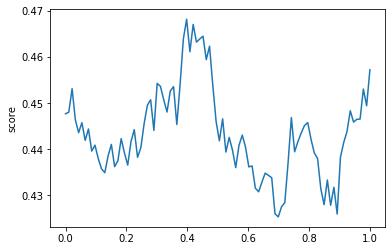

In [172]:
f = codecs.open('./imsdb_download_all_scripts/scripts\\10-Things-I-Hate-About-You.txt', "r", "utf8")
raw_text_clean = f.read()
f.close()
movie = '10ThingsIHateAboutYou'
window = 2000

ThingsIHateAboutYou = process_movie()

In [193]:
import glob
scripts = glob.glob('./imsdb_download_all_scripts/scripts/*.txt')

In [194]:
scripts

['./imsdb_download_all_scripts/scripts\\10-Things-I-Hate-About-You.txt',
 './imsdb_download_all_scripts/scripts\\12-and-Holding.txt',
 './imsdb_download_all_scripts/scripts\\12-Monkeys.txt',
 './imsdb_download_all_scripts/scripts\\12-Years-a-Slave.txt',
 './imsdb_download_all_scripts/scripts\\127-Hours.txt',
 './imsdb_download_all_scripts/scripts\\1492-Conquest-of-Paradise.txt',
 './imsdb_download_all_scripts/scripts\\15-Minutes.txt',
 './imsdb_download_all_scripts/scripts\\17-Again.txt',
 './imsdb_download_all_scripts/scripts\\187.txt',
 './imsdb_download_all_scripts/scripts\\2001-A-Space-Odyssey.txt',
 './imsdb_download_all_scripts/scripts\\2012.txt',
 './imsdb_download_all_scripts/scripts\\25th-Hour.txt',
 './imsdb_download_all_scripts/scripts\\28-Days-Later.txt',
 './imsdb_download_all_scripts/scripts\\30-Minutes-or-Less.txt',
 './imsdb_download_all_scripts/scripts\\42.txt',
 './imsdb_download_all_scripts/scripts\\44-Inch-Ches.txt',
 './imsdb_download_all_scripts/scripts\\48-Hrs.tx

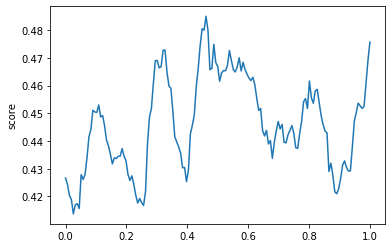

In [236]:
results[2][0].get_figure()

In [237]:
results = []
for idx, script in enumerate(scripts):
    file = codecs.open(script, "r", "utf8")
    raw_text_clean = file.read()
    file.close()
    name = script.split("\\",1)[1].replace('-', '').replace('.txt', '')
    movie = name
    window = 2000
    try:
        idx = process_movie()
        results.append(idx)
    except IndexError:
        pass
    print(movie)

length of the original parse
18600
length of the new parse
18600
2000
writing out the file to word-vectors/2000/10ThingsIHateAboutYou.csv
10ThingsIHateAboutYou
length of the original parse
18389
length of the new parse
18389
2000
writing out the file to word-vectors/2000/12andHolding.csv
12andHolding
length of the original parse
31204
length of the new parse
31204
2000
writing out the file to word-vectors/2000/12Monkeys.csv
12Monkeys
length of the original parse
30445
length of the new parse
30445
2000
writing out the file to word-vectors/2000/12YearsaSlave.csv
12YearsaSlave
length of the original parse
18376
length of the new parse
18376
2000
writing out the file to word-vectors/2000/127Hours.csv
127Hours
length of the original parse
22936
length of the new parse
22936
2000
writing out the file to word-vectors/2000/1492ConquestofParadise.csv
1492ConquestofParadise
length of the original parse
25344
length of the new parse
25344
2000
writing out the file to word-vectors/2000/15Minutes.

length of the new parse
25596
2000
writing out the file to word-vectors/2000/BachelorParty,The.csv
BachelorParty,The
length of the original parse
22000
length of the new parse
22000
2000
writing out the file to word-vectors/2000/BachelorParty.csv
BachelorParty
length of the original parse
20232
length of the new parse
20232
2000
writing out the file to word-vectors/2000/BackupPlan,The.csv
BackupPlan,The
length of the original parse
27107
length of the new parse
27107
2000
writing out the file to word-vectors/2000/Backdraf.csv
Backdraf
length of the original parse
26299
length of the new parse
26299
2000
writing out the file to word-vectors/2000/BadBoys.csv
BadBoys
length of the original parse
22650
length of the new parse
22650
2000
writing out the file to word-vectors/2000/BadCountry.csv
BadCountry
length of the original parse
21948
length of the new parse
21948
2000
writing out the file to word-vectors/2000/BadDayatBlackRock.csv
BadDayatBlackRock
length of the original parse
23324
le

writing out the file to word-vectors/2000/CedarRapids.csv
CedarRapids
length of the original parse
19588
length of the new parse
19588
2000
writing out the file to word-vectors/2000/Celeste&JesseForever.csv
Celeste&JesseForever
length of the original parse
21615
length of the new parse
21615
2000
writing out the file to word-vectors/2000/Cell,The.csv
Cell,The
length of the original parse
25777
length of the new parse
25777
2000
writing out the file to word-vectors/2000/Cellular.csv
Cellular
length of the original parse
22915
length of the new parse
22915
2000
writing out the file to word-vectors/2000/ChangeUp,The.csv
ChangeUp,The
length of the original parse
33290
length of the new parse
33290
2000
writing out the file to word-vectors/2000/Changeling.csv
Changeling
length of the original parse
20814
length of the new parse
20814
2000
writing out the file to word-vectors/2000/Chaos.csv
Chaos
length of the original parse
31082
length of the new parse
31082
2000
writing out the file to wo

16
length of the new parse
11
2000
Cube
length of the original parse
40495
length of the new parse
40495
2000
writing out the file to word-vectors/2000/CuriousCaseofBenjaminButton,The.csv
CuriousCaseofBenjaminButton,The
length of the original parse
15122
length of the new parse
15122
2000
writing out the file to word-vectors/2000/Custody.csv
Custody
length of the original parse
22019
length of the new parse
22019
2000
writing out the file to word-vectors/2000/DallasBuyersClub.csv
DallasBuyersClub
length of the original parse
20709
length of the new parse
20709
2000
writing out the file to word-vectors/2000/DamnedUnited,The.csv
DamnedUnited,The
length of the original parse
36687
length of the new parse
36687
2000
writing out the file to word-vectors/2000/DanceswithWolves.csv
DanceswithWolves
length of the original parse
27298
length of the new parse
27298
2000
writing out the file to word-vectors/2000/DarkCity.csv
DarkCity
length of the original parse
29891
length of the new parse
29891

length of the new parse
21804
2000
writing out the file to word-vectors/2000/Freaked.csv
Freaked
length of the original parse
25575
length of the new parse
25575
2000
writing out the file to word-vectors/2000/Freddyvs.Jason.csv
Freddyvs.Jason
length of the original parse
21093
length of the new parse
21093
2000
writing out the file to word-vectors/2000/FrenchConnection,The.csv
FrenchConnection,The
length of the original parse
5
length of the new parse
5
2000
Frequency
length of the original parse
17546
length of the new parse
17546
2000
writing out the file to word-vectors/2000/Fridaythe13.csv
Fridaythe13
length of the original parse
24749
length of the new parse
24749
2000
writing out the file to word-vectors/2000/Fridaythe13thPartVIIIJasonTakesManhattan.csv
Fridaythe13thPartVIIIJasonTakesManhattan
length of the original parse
20989
length of the new parse
20989
2000
writing out the file to word-vectors/2000/FrightNig.csv
FrightNig
length of the original parse
27267
length of the new 

length of the new parse
19547
2000
writing out the file to word-vectors/2000/HotTubTimeMachine.csv
HotTubTimeMachine
length of the original parse
24127
length of the new parse
24127
2000
writing out the file to word-vectors/2000/HotelRwanda.csv
HotelRwanda
length of the original parse
20764
length of the new parse
20764
2000
writing out the file to word-vectors/2000/Houseof1000Corpses.csv
Houseof1000Corpses
length of the original parse
22771
length of the new parse
22771
2000
writing out the file to word-vectors/2000/HowtoLoseFriends&AlienatePeople.csv
HowtoLoseFriends&AlienatePeople
length of the original parse
20604
length of the new parse
20604
2000
writing out the file to word-vectors/2000/HowtoTrainYourDragon2.csv
HowtoTrainYourDragon2
length of the original parse
21643
length of the new parse
21643
2000
writing out the file to word-vectors/2000/HowtoTrainYourDragon.csv
HowtoTrainYourDragon
length of the original parse
23534
length of the new parse
23534
2000
writing out the file 

22442
2000
writing out the file to word-vectors/2000/LifeofDavidGale,The.csv
LifeofDavidGale,The
length of the original parse
19376
length of the new parse
19376
2000
writing out the file to word-vectors/2000/LifeofPi.csv
LifeofPi
length of the original parse
26278
length of the new parse
26278
2000
writing out the file to word-vectors/2000/Life.csv
Life
length of the original parse
13718
length of the new parse
13718
2000
writing out the file to word-vectors/2000/LightSleeper.csv
LightSleeper
length of the original parse
19721
length of the new parse
19721
2000
writing out the file to word-vectors/2000/Limey,The.csv
Limey,The
length of the original parse
23549
length of the new parse
23549
2000
writing out the file to word-vectors/2000/Limitless.csv
Limitless
length of the original parse
24171
length of the new parse
24171
2000
writing out the file to word-vectors/2000/LincolnLawyer,The.csv
LincolnLawyer,The
length of the original parse
26925
length of the new parse
26925
2000
writing

writing out the file to word-vectors/2000/NewYorkMinute.csv
NewYorkMinute
length of the original parse
26133
length of the new parse
26133
2000
writing out the file to word-vectors/2000/Newsies.csv
Newsies
length of the original parse
24913
length of the new parse
24913
2000
writing out the file to word-vectors/2000/Nex.csv
Nex
length of the original parse
15919
length of the new parse
15919
2000
writing out the file to word-vectors/2000/NextFriday.csv
NextFriday
length of the original parse
26224
length of the new parse
26224
2000
writing out the file to word-vectors/2000/NextThreeDays,The.csv
NextThreeDays,The
length of the original parse
38299
length of the new parse
38299
2000
writing out the file to word-vectors/2000/Nivuniconnu.csv
Nivuniconnu
length of the original parse
20273
length of the new parse
20273
2000
writing out the file to word-vectors/2000/NickofTime.csv
NickofTime
length of the original parse
10689
length of the new parse
10689
2000
writing out the file to word-vec

writing out the file to word-vectors/2000/Road,The.csv
Road,The
length of the original parse
25648
length of the new parse
25648
2000
writing out the file to word-vectors/2000/RobinHoodPrinceofThieves.csv
RobinHoodPrinceofThieves
length of the original parse
25532
length of the new parse
25532
2000
writing out the file to word-vectors/2000/Rock,The.csv
Rock,The
length of the original parse
24048
length of the new parse
24048
2000
writing out the file to word-vectors/2000/RocknRolla.csv
RocknRolla
length of the original parse
15352
length of the new parse
15352
2000
writing out the file to word-vectors/2000/RockyHorrorPictureShow,The.csv
RockyHorrorPictureShow,The
length of the original parse
22634
length of the new parse
22625
2000
writing out the file to word-vectors/2000/Rocky.csv
Rocky
length of the original parse
22793
length of the new parse
22793
2000
writing out the file to word-vectors/2000/Romeo&Julie.csv
Romeo&Julie
length of the original parse
28103
length of the new parse
2

2000
writing out the file to word-vectors/2000/StraightOuttaCompton.csv
StraightOuttaCompton
length of the original parse
34922
length of the new parse
34922
2000
writing out the file to word-vectors/2000/StrangeDays.csv
StrangeDays
length of the original parse
28240
length of the new parse
28240
2000
writing out the file to word-vectors/2000/StrangersonaTrain.csv
StrangersonaTrain
length of the original parse
33653
length of the new parse
33653
2000
writing out the file to word-vectors/2000/Stuntman,The.csv
Stuntman,The
length of the original parse
3
length of the new parse
3
2000
SugarandSpice
length of the original parse
24256
length of the new parse
24256
2000
writing out the file to word-vectors/2000/Sugar.csv
Sugar
length of the original parse
23667
length of the new parse
23667
2000
writing out the file to word-vectors/2000/SunsetBlvd.csv
SunsetBlvd
length of the original parse
21933
length of the new parse
21933
2000
writing out the file to word-vectors/2000/SunshineCleaning.cs

writing out the file to word-vectors/2000/ToSleepwithAnger.csv
ToSleepwithAnger
length of the original parse
30205
length of the new parse
30205
2000
writing out the file to word-vectors/2000/ToKillAMockingbird.csv
ToKillAMockingbird
length of the original parse
30583
length of the new parse
30583
2000
writing out the file to word-vectors/2000/Tombstone.csv
Tombstone
length of the original parse
34517
length of the new parse
34517
2000
writing out the file to word-vectors/2000/TomorrowNeverDies.csv
TomorrowNeverDies
length of the original parse
6
length of the new parse
6
2000
TopGun
length of the original parse
19446
length of the new parse
19446
2000
writing out the file to word-vectors/2000/TotalReca.csv
TotalReca
length of the original parse
18940
length of the new parse
18940
2000
writing out the file to word-vectors/2000/Tourist,The.csv
Tourist,The
length of the original parse
43
length of the new parse
34
2000
ToyStory
length of the original parse
30125
length of the new parse
3

In [259]:
time_series = glob.glob('./timeseries/2000/*.csv')

In [262]:
dfs = [pd.read_csv(series, header=None) for series in time_series]

In [264]:
df_all = pd.concat(dfs, ignore_index=True, axis=0)

In [291]:
df_all.isnull().sum(axis=1).nlargest(5)

83     249
691    248
780    236
802    236
420    232
dtype: int64

In [284]:
pd.set_option('display.max_columns', None)

In [285]:
df_all.iloc[83:84]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
83,0.39011,0.39633,0.4013,0.406074,0.405839,0.404549,0.407645,0.409062,0.408176,0.402304,0.407091,0.408575,0.405624,0.400837,0.40053,0.401912,0.405592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
df_all[df_all.isnull().any(axis=1) == False]

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
561,0.513113,0.501988,0.4999,0.496989,0.493876,0.495358,0.493323,0.490258,0.486649,0.478016,...,0.460898,0.456412,0.455884,0.453487,0.454117,0.452983,0.455108,0.45697,0.459672,0.457973


In [292]:
df_matrix = df_all.copy()
df_matrix = df_matrix.fillna(0)

In [303]:
f_matrix = df_matrix.to_numpy()

In [305]:
f_matrix.shape

(1045, 266)

In [314]:
f_matrix_mean = np.tile(f_matrix.mean(axis=1),(266,1)).transpose()

In [316]:
f_matrix_mean.shape

(1045, 266)

In [ ]:
import scipy.cluster.hierarchy as hac

Z = hac.linkage(df_matrix, method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 50))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
               Z,
#                truncate_mode="lastp",
#                orientation="left",
               distance_sort="ascending",
#                leaf_label_func=llf,
               leaf_font_size=8,
)
plt.show()

In [361]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

#     # check the results
#     s = pd.Series(results)
#     clusters = s.unique()

#     for c in clusters:
#         cluster_indeces = s[s==c].index
#         print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
#         if plot:
#             timeSeries.T.iloc[:,cluster_indeces].plot()
#             plt.show()
    
    return results

array([ 20,  17,  17, ...,  66, 160,  50], dtype=int32)

In [540]:
results = print_clusters(df_matrix, Z, 100, plot=False)

In [541]:
results

array([16, 13, 13, ..., 44, 94, 33], dtype=int32)

In [542]:
uniqueValues, occurCount = np.unique(results, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Occurrence Count :  [14  8 15  8 12 14 12  7  8 11 12 10 13 12  7 10  2  8  2  7  5  9  8  6
  1  8  5  8  5  7  6  9 13  7  8  7 10  6  9  9  9 14  9  9 12  7  6  8
  9  5  3  3  7  9  5  7  7 10  2  1  5  6  3  2  3 25 20 15 19 19 18 17
  9 14 17 19 14 12 17 16 13 17 10 14 20 14 18 16 19 22 12 19  7 14 10 11
 14 16 15 14]


In [527]:
results = results.tolist()

In [528]:
df_matrix['cluster2'] = results

In [378]:
df_matrix['script'] = time_series

In [582]:
df_matrix[df_matrix['cluster2'] == 67]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,cluster,script,cluster2
106,0.414395,0.419132,0.424837,0.428843,0.428595,0.428491,0.431397,0.439275,0.439538,0.439030,0.440158,0.442576,0.435298,0.432328,0.433914,0.434640,0.435630,0.434751,0.438075,0.439742,0.438351,0.432205,0.438276,0.440287,0.435796,0.432393,0.427746,0.427338,0.421410,0.416117,0.414207,0.417593,0.414983,0.412445,0.409632,0.411848,0.413384,0.420387,0.426485,0.429832,0.429200,0.428440,0.430975,0.430899,0.436542,0.437851,0.445213,0.438835,0.434840,0.433261,0.431603,0.426739,0.423892,0.423991,0.423372,0.420370,0.412576,0.411882,0.411567,0.420562,0.430092,0.434999,0.432605,0.430742,0.436516,0.435889,0.440405,0.437881,0.437535,0.422590,0.416313,0.418667,0.421646,0.421272,0.415998,0.416639,0.416422,0.422591,0.432261,0.444648,0.449190,0.451763,0.455426,0.460671,0.463087,0.469966,0.472862,0.466310,0.460462,0.452779,0.448989,0.441330,0.439307,0.437441,0.432714,0.433234,0.432456,0.433808,0.438050,0.441232,0.443254,0.446740,0.445445,0.448497,0.454592,0.454462,0.456402,0.460896,0.462752,0.470430,0.478733,0.482774,0.484934,0.472571,0.473399,0.473292,0.472572,0.474011,0.468057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112,"./timeseries/2000\Avengers,The.csv",67
159,0.448272,0.446518,0.447814,0.447328,0.451965,0.456144,0.467477,0.468675,0.467045,0.465482,0.458842,0.459992,0.456998,0.455810,0.450451,0.440328,0.430259,0.438644,0.444815,0.448272,0.458421,0.463890,0.465708,0.463905,0.469166,0.473012,0.474152,0.469564,0.467898,0.461313,0.452877,0.448844,0.446907,0.451178,0.443325,0.444791,0.443633,0.441293,0.436508,0.435646,0.441388,0.447281,0.449940,0.448228,0.450647,0.457628,0.462554,0.466588,0.465206,0.463620,0.461002,0.457074,0.450281,0.448466,0.450344,0.438672,0.427257,0.419216,0.424229,0.430303,0.432618,0.431038,0.441901,0.446192,0.444821,0.454207,0.457773,0.466246,0.463000,0.460866,0.455827,0.455832,0.454299,0.453647,0.457972,0.458817,0.468378,0.464693,0.469568,0.466525,0.465502,0.464829,0.468355,0.469080,0.466736,0.465399,0.453682,0.449869,0.448479,0.451055,0.454926,0.456087,0.454373,0.460419,0.464549,0.459198,0.467665,0.468485,0.473179,0.475639,0.475036,0.475265,0.473222,0.469073,0.463385,0.472134,0.464828,0.465529,0.461328,0.460515,0.456770,0.454594,0.452646,0.447033,0.447427,0.437868,0.441778,0.443846,0.440534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [547]:
len(Z)

1044

In [419]:
time_series[100]

'./timeseries/2000\\AustinPowersInternationalManofMystery.csv'

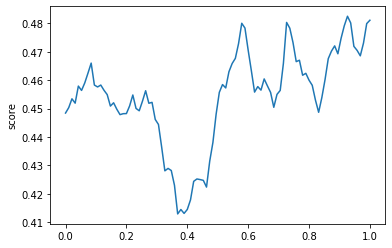

In [430]:
row100 = pd.read_csv('./timeseries/2000\\AustinPowersInternationalManofMystery.csv')
row100 = row100.T
row100 = row100.reset_index()
row100 = row100.rename(columns={"index": "score"})
row100['score'] = pd.to_numeric(row100['score'])
sns.lineplot(x=row100.index/max(row100.index), y="score", data=row100)

In [529]:
def cluster_plots(cluster):
    filter = df_matrix[df_matrix['cluster2'] == cluster]
    for i in range(filter.shape[0]):
        plotrow = pd.read_csv(filter.iloc[i]['script'])
        plotrow = plotrow.T
        plotrow = plotrow.reset_index()
        plotrow = plotrow.rename(columns={"index": "score"})
        plotrow['score'] = pd.to_numeric(plotrow['score'])
        plot = sns.lineplot(x=plotrow.index/max(plotrow.index), y="score", data=plotrow)
    plt.close()
    return plot

In [531]:
len(df_matrix[df_matrix['cluster2'] == ])

7

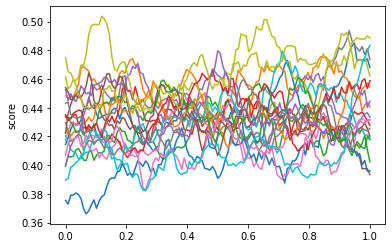

In [583]:
cluster_plots(67).get_figure()

In [585]:
df_matrix = df_matrix.drop(columns='cluster')

In [674]:
df_matrix['name_raw'] = df_matrix['script'].apply(lambda x: x.split("\\",1)[1].replace('-', '').replace('.csv', ''))

In [675]:
df_matrix.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,cluster2,name_raw
0,0.447656,0.448015,0.453089,0.446333,0.443578,0.445731,0.441900,0.444376,0.439587,0.440863,0.437936,0.435733,0.434909,0.438538,0.441023,0.436216,0.437491,0.442275,0.439186,0.436555,0.441620,0.444217,0.438239,0.440295,0.445466,0.449498,0.450683,0.444052,0.454226,0.453586,0.450693,0.448036,0.452584,0.453533,0.445335,0.453954,0.463862,0.468112,0.461082,0.466979,0.463173,0.463834,0.464443,0.459373,0.462275,0.453771,0.446030,0.441808,0.446569,0.439376,0.442548,0.439822,0.436002,0.440830,0.443039,0.440426,0.436166,0.436357,0.431554,0.430776,0.432857,0.434811,0.434331,0.433810,0.426026,0.425338,0.427528,0.428429,0.437077,0.446834,0.439440,0.441616,0.443478,0.445099,0.445752,0.442167,0.439203,0.438013,0.431443,0.427995,0.433323,0.427866,0.431744,0.425966,0.438263,0.441455,0.443800,0.448314,0.445861,0.446459,0.446504,0.453009,0.449387,0.457186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./timeseries/2000\10ThingsIHateAboutYou.csv,16,10ThingsIHateAboutYou
1,0.429479,0.432333,0.426568,0.426132,0.427532,0.427043,0.418813,0.420720,0.421534,0.424635,0.426202,0.429435,0.430972,0.432172,0.428658,0.428522,0.435251,0.435286,0.436219,0.433763,0.432920,0.429249,0.432645,0.428678,0.427314,0.424844,0.416946,0.417868,0.413796,0.411526,0.406043,0.407763,0.410734,0.414677,0.414251,0.417418,0.417867,0.414170,0.417409,0.422178,0.423880,0.418587,0.414506,0.415364,0.423169,0.424049,0.427100,0.431752,0.432339,0.430019,0.430289,0.434690,0.437083,0.440299,0.435641,0.433890,0.433954,0.434402,0.432267,0.433401,0.439493,0.441972,0.439857,0.432451,0.433935,0.432654,0.431487,0.426381,0.427877,0.435747,0.430715,0.434759,0.438871,0.444709,0.447712,0.452576,0.453574,0.455887,0.454787,0.450519,0.452254,0.445881,0.442112,0.442878,0.435319,0.432000,0.432000,0.433675,0.435276,0.433681,0.432650,0.430551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [709]:
import os
from urllib.parse import quote

from bs4 import BeautifulSoup
import requests

response = requests.get('http://www.imsdb.com/all%20scripts/')
html = response.text

soup = BeautifulSoup(html, "html.parser")
paragraphs = soup.find_all('p')

def get_titles():
    titles = []
    for p in paragraphs:
        title = p.a['title']
        title = title.rsplit(' ', 1)[0]
        titles.append(title)
    return titles

In [710]:
titles3 = get_titles()

In [712]:
moviename = pd.DataFrame(titles3, columns=['names'])

In [786]:
import difflib 

difflib.get_close_matches

def fuzzy_match():
    df_test = df_matrix.copy()
    clean_titles = []
    for i in range(len(df_matrix['script'])):
        try:
            matches = difflib.get_close_matches(df_matrix['name_raw'][i], moviename["names"])[0]
            if matches.endswith(", The"):
                matches = matches[:-5]
                matches = 'The ' + matches
                clean_titles.append(matches)
            elif matches.endswith(", A"):
                matches = matches[:-3]
                matches = 'A ' + matches
                clean_titles.append(matches)
            elif matches.endswith(", An"):
                matches = matches[:-4]
                matches = 'An ' + matches
                clean_titles.append(matches)
            else:
                clean_titles.append(matches)
        except IndexError:
            matches = np.nan
            clean_titles.append(matches)
    df_test['clean_titles'] = clean_titles
    return df_test

In [787]:
test6 = fuzzy_match()

In [788]:
test6[test6['clean_titles'].str.contains(", The") == True]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,cluster2,name_raw,clean_titles
105,0.463013,0.460379,0.465452,0.465932,0.468406,0.470313,0.474424,0.473995,0.479393,0.474003,0.478303,0.475969,0.468456,0.470380,0.467497,0.464806,0.467494,0.461931,0.462888,0.462964,0.459483,0.462988,0.465296,0.466839,0.464452,0.462977,0.458813,0.457436,0.455873,0.454868,0.455426,0.451452,0.452939,0.446746,0.445838,0.450812,0.454288,0.457229,0.454440,0.454747,0.451943,0.454000,0.454147,0.462868,0.466216,0.459842,0.455054,0.455519,0.456377,0.457792,0.463608,0.463482,0.458557,0.451917,0.453374,0.455974,0.461875,0.464093,0.463022,0.466043,0.463617,0.465672,0.467561,0.468170,0.464906,0.464842,0.465436,0.461735,0.467422,0.467223,0.470465,0.477240,0.485360,0.488146,0.492269,0.492951,0.488453,0.488179,0.480100,0.475629,0.475323,0.465919,0.460339,0.453812,0.449860,0.445636,0.446566,0.450204,0.454057,0.455991,0.455442,0.455967,0.454158,0.456930,0.461524,0.472521,0.476254,0.474833,0.474409,0.477117,0.473614,0.475225,0.477947,0.479836,0.480638,0.475131,0.471074,0.473017,0.471677,0.469894,0.468358,0.467806,0.467865,0.464567,0.459907,0.458558,0.458731,0.456383,0.457049,0.454267,0.458253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"./timeseries/2000\Avengers,The(2012).csv",92,"Avengers,The(2012)","Avengers, The (2012)"
644,0.463931,0.463351,0.458599,0.453253,0.455792,0.456214,0.451197,0.443673,0.440198,0.435568,0.427942,0.426683,0.425763,0.426307,0.421468,0.416080,0.414388,0.415885,0.413126,0.413458,0.412236,0.406587,0.404352,0.402482,0.403722,0.404817,0.406630,0.406705,0.407964,0.405201,0.410468,0.411963,0.407080,0.407893,0.398583,0.393451,0.390985,0.390279,0.388681,0.386525,0.380533,0.378314,0.380981,0.383529,0.387861,0.388797,0.392980,0.393683,0.394003,0.400192,0.401945,0.399631,0.397252,0.398906,0.399418,0.400231,0.388691,0.387388,0.386679,0.387303,0.392515,0.392265,0.397797,0.391905,0.396572,0.400825,0.411271,0.418034,0.421501,0.428066,0.423200,0.428943,0.432073,0.432533,0.432028,0.425723,0.422764,0.414508,0.410052,0.405472,0.405997,0.405413,0.403515,0.405976,0.405105,0.406943,0.410244,0.415785,0.420370,0.420789,0.419667,0.419515,0.421227,0.422773,0.423116,0.425247,0.426191,0.424644,0.419475,0.420416,0.422067,0.424324,0.423572,0.416134,0.414604,0.417094,0.415982,0.419469,0.425636,0.421673,0.419696,0.413911,0.412176,0.418579,0.414807,0.410592,0.407923,0.406340,0.409121,0.408121,0.414053,0.420428,0.423656,0.430601,0.437034,0.439469,0.440763,0.4

In [789]:
test6[test6['clean_titles'].isnull() == True]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,cluster2,name_raw,clean_titles
991,0.406931,0.41394,0.41586,0.41422,0.417536,0.408403,0.41497,0.420552,0.421701,0.421983,0.424639,0.42048,0.424188,0.425918,0.421154,0.430959,0.428475,0.425545,0.42145,0.426424,0.427955,0.432011,0.426727,0.431424,0.43797,0.441775,0.448051,0.450891,0.449516,0.447442,0.442425,0.440233,0.440741,0.430651,0.425948,0.424012,0.422235,0.418169,0.419233,0.418116,0.416015,0.415301,0.416015,0.420699,0.424372,0.423539,0.423149,0.428362,0.427295,0.428403,0.435789,0.439339,0.439822,0.440617,0.439511,0.441202,0.437586,0.44259,0.451147,0.451032,0.444542,0.43689,0.435204,0.434308,0.430819,0.42767,0.428869,0.416713,0.417459,0.41478,0.42333,0.43415,0.439484,0.43904,0.434728,0.428404,0.421719,0.427143,0.416396,0.424747,0.41912,0.415938,0.411211,0.413918,0.422774,0.430515,0.431722,0.42791,0.432214,0.43044,0.43315,0.43094,0.434202,0.428875,0.423684,0.420264,0.42808,0.428133,0.425748,0.421231,0.420423,0.422161,0.419312,0.420562,0.42363,0.426035,0.426099,0.430402,0.425762,0.418412,0.412045,0.413935,0.412964,0.415151,0.420817,0.428701,0.425774,0.428392,0.430638,0.441798,0.44558,0.44053,0.443221,0.448618,0.437556,0.428569,0.425426,0.422385,0.432968,0.429353,0.433106,0.432523,0.433286,0.431113,0.440248,0.443461,0.446555,0.446051,0.439629,0.436322,0.434305,0.436738,0.436691,0.437591,0.430027,0.425972,0.419098,0.419702,0.419332,0.42039,0.414776,0.410018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./timeseries/2000\ToKillAMockingbird.csv,39,ToKillAMockingbird,NaN


In [791]:
df_matrix['clean_titles'] = test6['clean_titles']

In [792]:
df_matrix[df_matrix['clean_titles'].str.contains(", The") == True]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,cluster2,name_raw,clean_titles
105,0.463013,0.460379,0.465452,0.465932,0.468406,0.470313,0.474424,0.473995,0.479393,0.474003,0.478303,0.475969,0.468456,0.470380,0.467497,0.464806,0.467494,0.461931,0.462888,0.462964,0.459483,0.462988,0.465296,0.466839,0.464452,0.462977,0.458813,0.457436,0.455873,0.454868,0.455426,0.451452,0.452939,0.446746,0.445838,0.450812,0.454288,0.457229,0.454440,0.454747,0.451943,0.454000,0.454147,0.462868,0.466216,0.459842,0.455054,0.455519,0.456377,0.457792,0.463608,0.463482,0.458557,0.451917,0.453374,0.455974,0.461875,0.464093,0.463022,0.466043,0.463617,0.465672,0.467561,0.468170,0.464906,0.464842,0.465436,0.461735,0.467422,0.467223,0.470465,0.477240,0.485360,0.488146,0.492269,0.492951,0.488453,0.488179,0.480100,0.475629,0.475323,0.465919,0.460339,0.453812,0.449860,0.445636,0.446566,0.450204,0.454057,0.455991,0.455442,0.455967,0.454158,0.456930,0.461524,0.472521,0.476254,0.474833,0.474409,0.477117,0.473614,0.475225,0.477947,0.479836,0.480638,0.475131,0.471074,0.473017,0.471677,0.469894,0.468358,0.467806,0.467865,0.464567,0.459907,0.458558,0.458731,0.456383,0.457049,0.454267,0.458253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"./timeseries/2000\Avengers,The(2012).csv",92,"Avengers,The(2012)","Avengers, The (2012)"
644,0.463931,0.463351,0.458599,0.453253,0.455792,0.456214,0.451197,0.443673,0.440198,0.435568,0.427942,0.426683,0.425763,0.426307,0.421468,0.416080,0.414388,0.415885,0.413126,0.413458,0.412236,0.406587,0.404352,0.402482,0.403722,0.404817,0.406630,0.406705,0.407964,0.405201,0.410468,0.411963,0.407080,0.407893,0.398583,0.393451,0.390985,0.390279,0.388681,0.386525,0.380533,0.378314,0.380981,0.383529,0.387861,0.388797,0.392980,0.393683,0.394003,0.400192,0.401945,0.399631,0.397252,0.398906,0.399418,0.400231,0.388691,0.387388,0.386679,0.387303,0.392515,0.392265,0.397797,0.391905,0.396572,0.400825,0.411271,0.418034,0.421501,0.428066,0.423200,0.428943,0.432073,0.432533,0.432028,0.425723,0.422764,0.414508,0.410052,0.405472,0.405997,0.405413,0.403515,0.405976,0.405105,0.406943,0.410244,0.415785,0.420370,0.420789,0.419667,0.419515,0.421227,0.422773,0.423116,0.425247,0.426191,0.424644,0.419475,0.420416,0.422067,0.424324,0.423572,0.416134,0.414604,0.417094,0.415982,0.419469,0.425636,0.421673,0.419696,0.413911,0.412176,0.418579,0.414807,0.410592,0.407923,0.406340,0.409121,0.408121,0.414053,0.420428,0.423656,0.430601,0.437034,0.439469,0.440763,0.4

In [793]:
df_matrix.iloc[991, df_matrix.columns.get_loc('clean_titles')] = 'To Kill a Mockingbird'

In [794]:
df_matrix.iloc[105, df_matrix.columns.get_loc('clean_titles')] = 'The Avengers'
df_matrix.iloc[644, df_matrix.columns.get_loc('clean_titles')] = 'The Majestic'

In [803]:
(df_matrix.iloc[644:645, 0:266] == 0).sum(axis=1)

644    126
dtype: int64

In [864]:
df_matrix[df_matrix['clean_titles'] == 'Apt Pupil']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,cluster2,name_raw,clean_titles
83,0.39011,0.39633,0.4013,0.406074,0.405839,0.404549,0.407645,0.409062,0.408176,0.402304,0.407091,0.408575,0.405624,0.400837,0.40053,0.401912,0.405592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,./timeseries/2000\AptPupi.csv,17,AptPupi,Apt Pupil


In [808]:
num_columns = list(range(0, 266, 1))

In [809]:
new_columns = [x/265 for x in num_columns]

In [920]:
value = df_matrix.iloc[83, 0:267].values.tolist()

In [912]:
len(value)

266

In [866]:
values = values.tolist()[0]

In [867]:
next((i for i, x in enumerate(values) if x == 0.0))

17

In [870]:
zeros = values[17:]

In [871]:
len(zeros)

249

In [872]:
values = values[:len(values)-249]

In [874]:
import itertools as IT

def evenly_spaced(*iterables):
    """
    >>> evenly_spaced(range(10), list('abc'))
    [0, 1, 'a', 2, 3, 4, 'b', 5, 6, 7, 'c', 8, 9]
    """
    return [item[1] for item in
            sorted(IT.chain.from_iterable(
            zip(IT.count(start=1.0 / (len(seq) + 1), 
                         step=1.0 / (len(seq) + 1)), seq)
            for seq in iterables))]

In [875]:
iterables = [values, zeros]

final_l = evenly_spaced(*iterables)

In [876]:
final_l

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3901100917431192,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.39632987012987,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4012995495495497,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4060741482965933,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.40583912248628906,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4045487603305787,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4076445578231294,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4090616438356164,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4081763698630136,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [878]:
import numpy as np
from scipy.interpolate import interp1d

y = np.array(final_l)
xnew = np.arange(len(y))

zero_idx = np.where(y==0)
xold = np.delete(xnew,zero_idx)
yold = np.delete(y, zero_idx)

print('before')
print(xold)
print(yold)

f = interp1d(xold,yold, fill_value="extrapolate")

ynew = f(xnew)

print()
print('after')
print(xnew)
print(ynew)

before
[ 13  28  43  58  73  88 103 118 132 147 162 177 192 207 222 237 252]
[0.39011009 0.39632987 0.40129955 0.40607415 0.40583912 0.40454876
 0.40764456 0.40906164 0.40817637 0.40230427 0.40709074 0.40857473
 0.40562425 0.40083705 0.40053    0.40191228 0.40559247]

after
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178

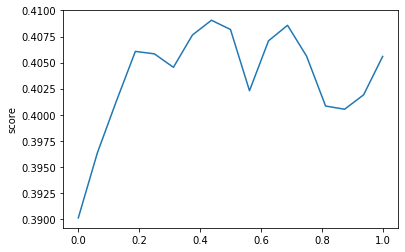

In [859]:
ro = pd.read_csv('./timeseries/2000/AptPupi.csv')
ro = ro.T
ro = ro.reset_index()
ro = ro.rename(columns={"index": "score"})
ro['score'] = pd.to_numeric(ro['score'])
sns.lineplot(x=ro.index/max(ro.index), y="score", data=ro)

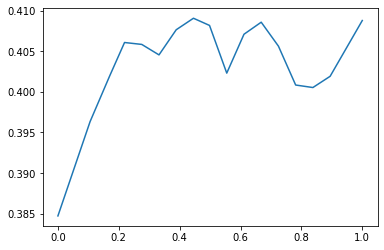

In [879]:
sns.lineplot(x=new_columns, y=ynew)

In [960]:
def interpolate(df):
    for i in range(df.shape[0]):
        try:
            values = df.iloc[i, 0:266].values.tolist()
            first_zero = next((item for item, x in enumerate(values) if x == 0.0))
            zeros = values[first_zero:]
            values = values[:len(values)-len(zeros)]

            iterables = [values, zeros]
            final_l = evenly_spaced(*iterables)

            y = np.array(final_l)
            xnew = np.arange(len(y))

            zero_idx = np.where(y==0)
            xold = np.delete(xnew,zero_idx)
            yold = np.delete(y, zero_idx)

            f = interp1d(xold,yold, fill_value="extrapolate")
            ynew = f(xnew)
            df.iloc[i, 0:266]=ynew
        except:
            pass
    return df

In [961]:
int_trial = df_matrix.copy()

In [962]:
df_interpolate = interpolate(int_trial)

In [965]:
null_columns=df_interpolate.columns[df_interpolate.isnull().any()]
df_interpolate[null_columns].isnull().sum()

Series([], dtype: float64)

In [994]:
from scipy.cluster.hierarchy import fcluster

import scipy.cluster.hierarchy as hac

Z = hac.linkage(df_interpolate.iloc[:,0:266], method='ward', metric='euclidean')

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    
    return results

In [997]:
results = print_clusters(df_interpolate, Z, 100, plot=False)
uniqueValues, occurCount = np.unique(results, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Occurrence Count :  [ 2  6 12 10  7  6 21  9  4  8  8  9  6  6 15 10 17 13  4  6  5  4  4  1
  2  5 12  7  5  4 10 17  5 25 17 11 12  5  7 10 20  4 12 12  7  5  9 11
  3 17  9 15 23  7  1  8 23 14  4  8 13 15  8  4  9 22  3 15 21 10  5 21
 16  5 19 23  2  7  7  9 14 21  6  8 13 15 18 14 10 18  2  2  9 15 11 15
 18 28  6  9]


In [983]:
df_interpolate['cluster3'] = results

In [984]:
def cluster_plots(cluster):
    filter = df_interpolate[df_interpolate['cluster3'] == cluster]
    for i in range(filter.shape[0]):
        plotrow = pd.read_csv(filter.iloc[i]['script'])
        plotrow = plotrow.T
        plotrow = plotrow.reset_index()
        plotrow = plotrow.rename(columns={"index": "score"})
        plotrow['score'] = pd.to_numeric(plotrow['score'])
        plot = sns.lineplot(x=plotrow.index/max(plotrow.index), y="score", data=plotrow)
    plt.close()
    return plot

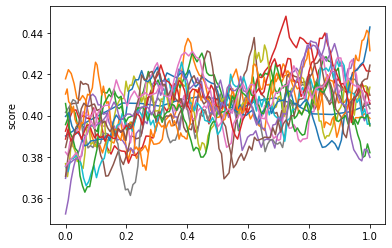

In [1021]:
cluster_plots(32).get_figure()

In [1005]:
df_interpolate = df_interpolate.drop(columns='cluster2')

In [1006]:
df_interpolate.to_csv('data_interpolate.csv')

In [1022]:
df_interpolate[df_interpolate['cluster3'] == 32]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,name_raw,clean_titles,cluster3
83,0.384720,0.385134,0.385549,0.385964,0.386378,0.386793,0.387208,0.387622,0.388037,0.388451,0.388866,0.389281,0.389695,0.390110,0.390525,0.390939,0.391354,0.391769,0.392183,0.392598,0.393013,0.393427,0.393842,0.394257,0.394671,0.395086,0.395501,0.395915,0.396330,0.396661,0.396992,0.397324,0.397655,0.397986,0.398318,0.398649,0.398980,0.399312,0.399643,0.399974,0.400306,0.400637,0.400968,0.401300,0.401618,0.401936,0.402254,0.402573,0.402891,0.403209,0.403528,0.403846,0.404164,0.404483,0.404801,0.405119,0.405438,0.405756,0.406074,0.406058,0.406043,0.406027,0.406011,0.405996,0.405980,0.405964,0.405949,0.405933,0.405917,0.405902,0.405886,0.405870,0.405855,0.405839,0.405753,0.405667,0.405581,0.405495,0.405409,0.405323,0.405237,0.405151,0.405065,0.404979,0.404893,0.404807,0.404721,0.404635,0.404549,0.404755,0.404962,0.405168,0.405374,0.405581,0.405787,0.405993,0.406200,0.406406,0.406613,0.406819,0.407025,0.407232,0.407438,0.407645,0.407739,0.407834,0.407928,0.408022,0.408117,0.408211,0.408306,0.408400,0.408495,0.408589,0.408684,0.408778,0.408873,0.408967,0.409062,0.408998,0.408935,0.408872,0.408809,0.408745,0.408682,0.408619,0.408556,0.408493,0.408429,0.408366,0.408303,0.408240,0.408176,0.407785,0.407393,0.407002,0.406610,0.406219,0.405828,0.405436,0.405045,0.404653,0.404262,0.403870,0.403479,0.403087,0.402696,0.402304,0.402623,0.402942,0.403262,0.403581,0.403900,0.404219,0.404538,0.404857,0.405176,0.405495,0.405814,0.406133,0.406453,0.406772,0.407091,0.407190,0.407289,0.407388,0.407486,0.407585,0.407684,0.407783,0.407882,0.407981,0.408080,0.408179,0.408278,0.408377,0.408476,0.408575,0.408378,0.408181,0.407985,0.407788,0.407591,0.407395,0.407198,0.407001,0.406804,0.406608,0.406411,0.406214,0.406018,0.405821,0.405624,0.405305,0.404986,0.404667,0.404348,0.404029,0.403709,0.403390,0.403071,0.402752,0.402433,0.402114,0.401794,0.401475,0.401156,0.400837,0.400817,0.400796,0.400776,0.400755,0.400735,0.400714,0.400694,0.400673,0.400653,0.400632,0.400612,0.400591,0.400571,0.400550,0.400530,0.400622,0.400714,0.400806,0.400899,0.400991,0.401083,0.401175,0.401267,0.401359,0.401452,0.401544,0.401636,0.401728,0.401820,0.401912,0.402158,0.402403,0.402648,0.402894,0.403139,0.403384,0.403630,0.403875,0.404120,0.404366,0.404611,0.404856,0.405102,0.405347,0.405592,0.405838,0.406083,0.406329,0.406574,0.406819,0.407065,0.407310,0.407555,0.407801,0.408046,0.408291,0.408537,0.408782,./timeseries/2000\AptPupi.csv,AptPupi,Apt Pupil,32
95,0.415603,0.417801,0.419999,0.422197,0.421577,0.420957,0.420337,0.417932,0.415527,0.413124,0.410721,0.408319,0.407857,0.407395,0.408160,0.408925,0.409690,0.408696,0.407702,0.405569,0.403436,0.401303,0.396162,0.391020,0.389739,0.388457,0.387176,0.385933,0.384690,0.385270,0.385851,0.384546,0.383242,0.381938,0.384261,0.386584,0.387261,0.387937,0.388614,0.388044,0.387474,0.387220,0.386965,0.386711,0.389094,0.391478,0.394244,0.397011,0.399778,0.396001,0.392224,0.390773,0.389323,0.387872,0.383031,0.378190,0.380107,0.382025,0.383942,0.383403,0.382863,0.38106

In [1020]:
df_interpolate[df_interpolate['clean_titles'] == 'Apt Pupil']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,script,name_raw,clean_titles,cluster3
83,0.38472,0.385134,0.385549,0.385964,0.386378,0.386793,0.387208,0.387622,0.388037,0.388451,0.388866,0.389281,0.389695,0.39011,0.390525,0.390939,0.391354,0.391769,0.392183,0.392598,0.393013,0.393427,0.393842,0.394257,0.394671,0.395086,0.395501,0.395915,0.39633,0.396661,0.396992,0.397324,0.397655,0.397986,0.398318,0.398649,0.39898,0.399312,0.399643,0.399974,0.400306,0.400637,0.400968,0.4013,0.401618,0.401936,0.402254,0.402573,0.402891,0.403209,0.403528,0.403846,0.404164,0.404483,0.404801,0.405119,0.405438,0.405756,0.406074,0.406058,0.406043,0.406027,0.406011,0.405996,0.40598,0.405964,0.405949,0.405933,0.405917,0.405902,0.405886,0.40587,0.405855,0.405839,0.405753,0.405667,0.405581,0.405495,0.405409,0.405323,0.405237,0.405151,0.405065,0.404979,0.404893,0.404807,0.404721,0.404635,0.404549,0.404755,0.404962,0.405168,0.405374,0.405581,0.405787,0.405993,0.4062,0.406406,0.406613,0.406819,0.407025,0.407232,0.407438,0.407645,0.407739,0.407834,0.407928,0.408022,0.408117,0.408211,0.408306,0.4084,0.408495,0.408589,0.408684,0.408778,0.408873,0.408967,0.409062,0.408998,0.408935,0.408872,0.408809,0.408745,0.408682,0.408619,0.408556,0.408493,0.408429,0.408366,0.408303,0.40824,0.408176,0.407785,0.407393,0.407002,0.40661,0.406219,0.405828,0.405436,0.405045,0.404653,0.404262,0.40387,0.403479,0.403087,0.402696,0.402304,0.402623,0.402942,0.403262,0.403581,0.4039,0.404219,0.404538,0.404857,0.405176,0.405495,0.405814,0.406133,0.406453,0.406772,0.407091,0.40719,0.407289,0.407388,0.407486,0.407585,0.407684,0.407783,0.407882,0.407981,0.40808,0.408179,0.408278,0.408377,0.408476,0.408575,0.408378,0.408181,0.407985,0.407788,0.407591,0.407395,0.407198,0.407001,0.406804,0.406608,0.406411,0.406214,0.406018,0.405821,0.405624,0.405305,0.404986,0.404667,0.404348,0.404029,0.403709,0.40339,0.403071,0.402752,0.402433,0.402114,0.401794,0.401475,0.401156,0.400837,0.400817,0.400796,0.400776,0.400755,0.400735,0.400714,0.400694,0.400673,0.400653,0.400632,0.400612,0.400591,0.400571,0.40055,0.40053,0.400622,0.400714,0.400806,0.400899,0.400991,0.401083,0.401175,0.401267,0.401359,0.401452,0.401544,0.401636,0.401728,0.40182,0.401912,0.402158,0.402403,0.402648,0.402894,0.403139,0.403384,0.40363,0.403875,0.40412,0.404366,0.404611,0.404856,0.405102,0.405347,0.405592,0.405838,0.406083,0.406329,0.406574,0.406819,0.407065,0.40731,0.407555,0.407801,0.408046,0.408291,0.408537,0.408782,./timeseries/2000\AptPupi.csv,AptPupi,Apt Pupil,32


In [1025]:
d = dict(zip(df_interpolate.columns[0:266], new_columns))
df_interpolate = df_interpolate.rename(columns=d)

In [1027]:
df_interpolate.head(20)

,0.0,0.0037735849056603774,0.007547169811320755,0.011320754716981131,0.01509433962264151,0.018867924528301886,0.022641509433962263,0.026415094339622643,0.03018867924528302,0.033962264150943396,0.03773584905660377,0.04150943396226415,0.045283018867924525,0.04905660377358491,0.052830188679245285,0.05660377358490566,0.06037735849056604,0.06415094339622641,0.06792452830188679,0.07169811320754717,0.07547169811320754,0.07924528301886792,0.0830188679245283,0.08679245283018867,0.09056603773584905,0.09433962264150944,0.09811320754716982,0.1018867924528302,0.10566037735849057,0.10943396226415095,0.11320754716981132,0.1169811320754717,0.12075471698113208,0.12452830188679245,0.12830188679245283,0.1320754716981132,0.13584905660377358,0.13962264150943396,0.14339622641509434,0.1471698113207547,0.1509433962264151,0.15471698113207547,0.15849056603773584,0.16226415094339622,0.1660377358490566,0.16981132075471697,0.17358490566037735,0.17735849056603772,0.1811320754716981,0.18490566037735848,0.18867924528301888,0.19245283018867926,0.19622641509433963,0.2,0.2037735849056604,0.20754716981132076,0.21132075471698114,0.21509433962264152,0.2188679245283019,0.22264150943396227,0.22641509433962265,0.23018867924528302,0.2339622641509434,0.23773584905660378,0.24150943396226415,0.24528301886792453,0.2490566037735849,0.2528301886792453,0.25660377358490566,0.26037735849056604,0.2641509433962264,0.2679245283018868,0.27169811320754716,0.27547169811320754,0.2792452830188679,0.2830188679245283,0.28679245283018867,0.29056603773584905,0.2943396226415094,0.2981132075471698,0.3018867924528302,0.30566037735849055,0.30943396226415093,0.3132075471698113,0.3169811320754717,0.32075471698113206,0.32452830188679244,0.3283018867924528,0.3320754716981132,0.33584905660377357,0.33962264150943394,0.3433962264150943,0.3471698113207547,0.35094339622641507,0.35471698113207545,0.3584905660377358,0.3622641509433962,0.3660377358490566,0.36981132075471695,0.37358490566037733,0.37735849056603776,0.38113207547169814,0.3849056603773585,0.3886792452830189,0.39245283018867927,0.39622641509433965,0.4,0.4037735849056604,0.4075471698113208,0.41132075471698115,0.41509433962264153,0.4188679245283019,0.4226415094339623,0.42641509433962266,0.43018867924528303,0.4339622641509434,0.4377358490566038,0.44150943396226416,0.44528301886792454,0.4490566037735849,0.4528301886792453,0.45660377358490567,0.46037735849056605,0.4641509433962264,0.4679245283018868,0.4716981132075472,0.47547169811320755,0.47924528301886793,0.4830188679245283,0.4867924528301887,0.49056603773584906,0.49433962264150944,0.4981132075471698,0.5018867924528302,0.5056603773584906,0.5094339622641509,0.5132075471698113,0.5169811320754717,0.5207547169811321,0.5245283018867924,0.5283018867924528,0.5320754716981132,0.5358490566037736,0.539622641509434,0.5433962264150943,0.5471698113207547,0.5509433962264151,0.5547169811320755,0.5584905660377358,0.5622641509433962,0.5660377358490566,0.569811320754717,0.5735849056603773,0.5773584905660377,0.5811320754716981,0.5849056603773585,0.5886792452830188,0.5924528301886792,0.5962264150943396,0.6,0.6037735849056604,0.6075471698113207,0.6113207547169811,0.6150943396226415,0.6188679245283019,0.6226415094339622,0.6264150943396226,0.630188679245283,0.6339622641509434,0.6377358490566037,0.6415094339622641,0.6452830188679245,0.6490566037735849,0.6528301886792452,0.6566037735849056,0.660377358490566,0.6641509433962264,0.6679245283018868,0.6716981132075471,0.6754716981132075,0.6792452830188679,0.6830188679245283,0.6867924528301886,0.690566037735849,0.6943396226415094,0.6981132075471698,0.7018867924528301,0.7056603773584905,0.7094339622641509,0.7132075471698113,0.7169811320754716,0.720754716981132,0.7245283018867924,0.7283018867924528,0.7320754716981132,0.7358490566037735,0.7396226415094339,0.7433962264150943,0.7471698113207547,0.7509433962264151,0.7547169811320755,0.7584905660377359,0.7622641509433963,0.7660377358490567,0.769811320754717,0.7735849056603774,0.7773584905660378,0.7811320754716982,0.7849056603773585,

In [1028]:
df_interpolate.to_csv('data_interpolate.csv')

In [421]:
df_interpolate = pd.read_csv('data_interpolate.csv', encoding = 'utf-8')

In [286]:
r = df_interpolate[df_interpolate['name_raw'] == 'Schindler\'s List']

In [422]:
df_interpolate.head()

,Unnamed: 0,0.0,0.0037735849056603774,0.007547169811320755,0.011320754716981131,0.01509433962264151,0.018867924528301886,0.022641509433962263,0.026415094339622643,0.03018867924528302,...,0.9811320754716981,0.9849056603773585,0.9886792452830189,0.9924528301886792,0.9962264150943396,1.0,script,name_raw,clean_titles,cluster3
0,0,0.447536,0.447656,0.447776,0.447895,0.448015,0.449706,0.451398,0.453089,0.450837,...,0.450595,0.449387,0.451987,0.454586,0.457186,0.459786,./timeseries/2000\10ThingsIHateAboutYou.csv,10ThingsIHateAboutYou,10 Things I Hate About You,57
1,1,0.428528,0.429479,0.430430,0.431381,0.432333,0.430411,0.428490,0.426568,0.426423,...,0.432994,0.432650,0.431951,0.431251,0.430551,0.429851,./timeseries/2000\127Hours.csv,127Hours,127 Hours,73
2,2,0.410206,0.412142,0.414077,0.416013,0.417948,0.417581,0.417213,0.416845,0.418652,...,0.445592,0.447011,0.447189,0.447366,0.447543,0.447721,./timeseries/2000\12andHolding.csv,12andHolding,12 and Holding,82
3,3,0.426636,0.425461,0.424286,0.422299,0.420311,0.418809,0.416241,0.413674,0.415340,...,0.452460,0.460908,0.464980,0.469052,0.472363,0.475675,./timeseries/2000\12Monkeys.csv,12Monkeys,12 Monkeys,13
4,4,0.433821,0.433510,0.433198,0.433181,0.433163,0.429145,0.427096,0.425047,0.425301,...,0.424043,0.428555,0.429356,0.430157,0.429395,0.428632,./timeseries/2000\12YearsaSlave.csv,12YearsaSlave,12 Years a Slave,54


In [423]:
df_interpolate = df_interpolate.drop(columns=['Unnamed: 0'])

In [424]:
df_interpolate['clean_titles'] = df_interpolate['clean_titles'].apply(lambda x: x.translate(str.maketrans({"-":  r"\-",
                                          "]":  r"\]",
                                          "(":  r"\(",
                                          ")":  r"\)",
                                          "\\": r"\\",
                                          "&" : r"\&",
                                          "'" : r"\'",
                                          ":" : r"\:",
                                          "^":  r"\^",
                                          "$":  r"\$",
                                          "*":  r"\*",
                                          ".":  r"\."})))

In [357]:
test = "ways to make a 30 cat and 50 times"
re.findall(r'\d+', test)

['30', '50']

In [369]:
test = "ways to make a 30 cat"
expr = r'\\3' + first + ' '
re.sub(r'\d', expr, test, count=1)

'ways to make a \\33 0 cat'

In [396]:
def sub_num(string):
    digits = re.findall(r'\d+', string)
    if digits:
        for i in range(len(digits)):
            if i==0:
                expr = r'\\3' + digits[i][:1] + ' '
                new_string = re.sub(digits[i][:1], expr, string)
            else:
                expr = r'\\3' + digits[i][:1] + ' '
                new_string = re.sub(digits[i][:1], expr, new_string)
    else:
        new_string = string
    return new_string

In [404]:
sub_num("2002")

'\\32 00\\32 '

In [425]:
df_interpolate['clean_titles'] = df_interpolate['clean_titles'].apply(lambda x: sub_num(x))

In [426]:
df_interpolate.to_csv('data_interpolate_escape.csv')

In [427]:
print(df_interpolate['clean_titles'].tolist())

['\\31 0 Things I Hate About You', '\\31 27 Hours', '\\31 2 and Holding', '\\31 2 Monkeys', '\\31 2 Years a Slave', '\\31 492\\: Conquest of Paradise', '\\31 5 Minutes', '\\31 7 Again', '\\31 87', '\\32 001\\: A Space Odyssey', '\\32 01\\32 ', '\\32 5th Hour', '\\32 8 Days Later', '\\33 0 Minutes or Less', '\\34 2', '\\34 \\34  Inch Chest', '\\35 00 Days of Summer', '\\3\\35  0\\-\\3\\35  0', '\\38 MM', '\\39 ', 'Above the Law', 'Absolute Power', 'The Abyss', 'Adaptation', 'The Addams Family', 'The Adjustment Bureau', 'The Adventures of Buckaroo Banzai Across the Eighth Dimension', 'A Few Good Men', 'Affliction', 'After\\.Life', 'After School Special', 'Agnes of God', 'Airplane', 'Airplane \\32 \\: The Sequel', 'Aladdin', 'Ali', 'Alien', 'Alien \\33 ', 'Alien Nation', 'Alien\\: Resurrection', 'Aliens', 'Alien vs\\. Predator', 'All About Eve', 'All About Steve', "All the King\\'s Men", "All the President\\'s Men", 'Alone in the Dark', 'Amadeus', 'Amelia', 'The American', 'American Beaut

In [1047]:
export = df_interpolate.to_json(r'data.json',orient='index')

In [1041]:
test_index = df_interpolate.copy()

In [1032]:
d2 = dict(zip(df_interpolate.columns, [str]*270))

In [ ]:
import pandas as pd
from itertools import groupby 
from collections import OrderedDict
import json    

df = pd.read_csv('data_interpolate.csv', dtype=d2)

results = []

for (clean_titles), bag in df_interpolate.groupby(["clean_titles"]):
    contents_df = bag.drop(["clean_titles"], axis=1)
    subset = [OrderedDict(row) for i,row in contents_df.iterrows()]
    results.append(OrderedDict([("clean_titles", clean_titles),
                                ("title", subset)]))

print(json.dumps(results[0], indent=4))
#with open('ExpectedJsonFile.json', 'w') as outfile:
#    outfile.write(json.dumps(results[0], indent=4))

In [9]:
test_two = df_interpolate.copy()

In [1053]:
big_list = []
for i in range(test_two.shape[0]):
    scores = test_two.iloc[i, 0:266].values.tolist()
    big_list.append(scores)

In [23]:
def json_array():
    output = {}
    dictionaries = []
    for i, movie in enumerate(test_two['clean_titles']):
        for j in range(266):
            row_dict = dict({"percent": str(test_two.columns[j]), "score": str(test_two.iloc[i,j]), "cluster": str(test_two['cluster3'][i])})
            dictionaries.append(row_dict)
        movie_data = dict({movie: dictionaries})}
        output.update(movie_data)
    return output

In [ ]:
# def json_array():
#     output = {}
#     dictionaries = []
#     for i, movie in enumerate(test_two['clean_titles']):
#         for j in range(266):
#             row_dict = dict({"percent": str(test_two.columns[j]), "score": str(test_two.iloc[i,j])})
#             dictionaries.append(row_dict)
#         movie_data = dict({movie: dict({"cluster": str(test_two['cluster3'][i]), "data": dictionaries})})
#         output.update(movie_data)
#     return output

In [24]:
json_array = json_array()

In [ ]:
import json
with open('output2.json', 'w') as outfile:
   outfile.write(json.dumps(json_array, indent=4))

In [15]:
t = df_interpolate['clean_titles'].tolist()

In [24]:
n = df_interpolate.iloc[:,1:267].columns.tolist()

In [25]:
h = [float(i) for i in n]

In [26]:
h

[0.0,
 0.0037735849056603774,
 0.007547169811320755,
 0.011320754716981131,
 0.01509433962264151,
 0.018867924528301886,
 0.022641509433962263,
 0.026415094339622643,
 0.03018867924528302,
 0.033962264150943396,
 0.03773584905660377,
 0.04150943396226415,
 0.045283018867924525,
 0.04905660377358491,
 0.052830188679245285,
 0.05660377358490566,
 0.06037735849056604,
 0.06415094339622641,
 0.06792452830188679,
 0.07169811320754717,
 0.07547169811320754,
 0.07924528301886792,
 0.0830188679245283,
 0.08679245283018867,
 0.09056603773584905,
 0.09433962264150944,
 0.09811320754716982,
 0.1018867924528302,
 0.10566037735849057,
 0.10943396226415095,
 0.11320754716981132,
 0.1169811320754717,
 0.12075471698113208,
 0.12452830188679245,
 0.12830188679245283,
 0.1320754716981132,
 0.13584905660377358,
 0.13962264150943396,
 0.14339622641509434,
 0.1471698113207547,
 0.1509433962264151,
 0.15471698113207547,
 0.15849056603773584,
 0.16226415094339622,
 0.1660377358490566,
 0.16981132075471697,
 

In [138]:
def predictions(input):
    filtered = df_interpolate[df_interpolate['clean_titles'] == input]
    cluster = filtered['cluster3'].values[0]
    movies = df_interpolate[df_interpolate['cluster3'] == cluster]
    if len(movies) < 6:
        movies = df_interpolate[(df_interpolate['cluster3'] == cluster) | 
                                (df_interpolate['cluster3'] == cluster+1) |
                                (df_interpolate['cluster3'] == cluster-1)]
    else:
        movies = df_interpolate[df_interpolate['cluster3'] == cluster]
    if input in movies['clean_titles'].tolist():
        all = movies
    else:
        all = pd.concat([filtered, movies], axis=0)
    if all['clean_titles'].tolist()[0] != input:
        all = all.reset_index(drop=True)
        ind = all.index[all['clean_titles'] == input].tolist()[0]
        m1, m2 = all.iloc[0].copy(), all.iloc[ind].copy()
        all.iloc[0], all.iloc[ind] = m2,m1
    if 'Unnamed: 0' in all.columns:
        all = all.drop(columns=['Unnamed: 0'])
    final = all.iloc[0:6]
    return final

In [280]:
final = predictions('Edward Scissorhands')

In [281]:
final

,0.0,0.0037735849056603774,0.007547169811320755,0.011320754716981131,0.01509433962264151,0.018867924528301886,0.022641509433962263,0.026415094339622643,0.03018867924528302,0.033962264150943396,...,0.9811320754716981,0.9849056603773585,0.9886792452830189,0.9924528301886792,0.9962264150943396,1.0,script,name_raw,clean_titles,cluster3
0,0.410135,0.409914,0.409694,0.409473,0.409253,0.409032,0.408811,0.408591,0.408370,0.408150,...,0.448512,0.448813,0.449114,0.449415,0.449716,0.450017,./timeseries/2000\EdwardScissorhands.csv,EdwardScissorhands,Edward Scissorhands,69
1,0.432419,0.431555,0.430692,0.429828,0.428964,0.428101,0.428595,0.429089,0.429584,0.429468,...,0.418239,0.418885,0.419531,0.420178,0.420824,0.421470,./timeseries/2000\AmericanMilkshake.csv,AmericanMilkshake,American Milkshake,69
2,0.408736,0.412391,0.416046,0.419701,0.423356,0.424211,0.425066,0.425341,0.425616,0.425891,...,0.448345,0.449953,0.451949,0.453946,0.455943,0.457940,./timeseries/2000\AmericanPsycho.csv,AmericanPsycho,American Psycho,69
3,0.434325,0.431561,0.428797,0.428553,0.428309,0.428043,0.427777,0.429467,0.431157,0.433890,...,0.442749,0.441670,0.443009,0.444348,0.442405,0.440461,./timeseries/2000\AnnieHa.csv,AnnieHa,Annie Hall,69
4,0.399276,0.403667,0.408058,0.412449,0.416026,0.419604,0.421483,0.423362,0.425241,0.425294,...,0.445242,0.441416,0.437590,0.438562,0.439534,0.440506,./timeseries/2000\BadDreams.csv,BadDreams,Bad Dreams,69
5,0.423384,0.423872,0.424359,0.423830,0.423301,0.421336,0.419370,0.417588,0.415805,0.414915,...,0.447752,0.450419,0.449911,0.449403,0.448442,0.447481,./timeseries/2000\BoogieNights.csv,BoogieNights,Boogie Nights,69


In [191]:
def json_array():
    output = {}
    dictionaries = []
    for i, movie in enumerate(final['clean_titles']):
        for j in range(266):
            row_dict = dict({"percent": str(final.columns[j]), "score": str(final.iloc[i,j]), "cluster": str(final['cluster3'].values[i])})
            dictionaries.append(row_dict)
        movie_data = dict({movie: dictionaries})
        output.update(movie_data)
    return output

In [211]:
d = final.copy()

In [221]:
e = d.iloc[:,260:270]

In [275]:
from collections import OrderedDict

In [277]:
def json_array():
    output = {}
    dictionaries = []
    for i, movie in enumerate(e['clean_titles']):
        for j in range(6):
            row_dict = dict({"percent": str(e.columns[j]), "score": str(e.iloc[i,j]), "cluster": str(e['cluster3'].values[i])})
            dictionaries.append(row_dict)
        movie_data = dict({movie: dictionaries})
        output.update(movie_data)
        dictionaries = []
    return output

In [278]:
test26= json_array()

In [279]:
test26

{'15 Minutes': [{'percent': '0.9811320754716981',
   'score': '0.5275169491525423',
   'cluster': '20'},
  {'percent': '0.9849056603773585',
   'score': '0.530151503422425',
   'cluster': '20'},
  {'percent': '0.9886792452830189',
   'score': '0.5327860576923077',
   'cluster': '20'},
  {'percent': '0.9924528301886792',
   'score': '0.5383820398351647',
   'cluster': '20'},
  {'percent': '0.9962264150943396',
   'score': '0.5439780219780218',
   'cluster': '20'},
  {'percent': '1.0', 'score': '0.5495740041208789', 'cluster': '20'}],
 'Candle to Water': [{'percent': '0.9811320754716981',
   'score': '0.4949750932140193',
   'cluster': '20'},
  {'percent': '0.9849056603773585', 'score': '0.4939', 'cluster': '20'},
  {'percent': '0.9886792452830189',
   'score': '0.4913217030114226',
   'cluster': '20'},
  {'percent': '0.9924528301886792',
   'score': '0.4887434060228453',
   'cluster': '20'},
  {'percent': '0.9962264150943396',
   'score': '0.4861651090342679',
   'cluster': '20'},
  {'p

In [433]:
# url = "http://localhost:5000/api"
url = "https://storyplotsapp.herokuapp.com/api"

In [458]:
import json
input = json.dumps({"movie_title": "Hellboy \\32 \\: The Golden Army"})

In [459]:
import requests
send = requests.post(url, input)

In [460]:
print(send.json())

{'Backdraft': [{'cluster': '57', 'percent': '0.0', 'score': '0.451129943502825'}, {'cluster': '57', 'percent': '0.0037735849056603774', 'score': '0.4498564409457254'}, {'cluster': '57', 'percent': '0.007547169811320755', 'score': '0.4485829383886259'}, {'cluster': '57', 'percent': '0.011320754716981131', 'score': '0.4464169712023452'}, {'cluster': '57', 'percent': '0.01509433962264151', 'score': '0.4442510040160645'}, {'cluster': '57', 'percent': '0.018867924528301886', 'score': '0.4451741976602063'}, {'cluster': '57', 'percent': '0.022641509433962263', 'score': '0.4460973913043481'}, {'cluster': '57', 'percent': '0.026415094339622643', 'score': '0.4465026127028653'}, {'cluster': '57', 'percent': '0.03018867924528302', 'score': '0.4469078341013824'}, {'cluster': '57', 'percent': '0.033962264150943396', 'score': '0.4462712654286883'}, {'cluster': '57', 'percent': '0.03773584905660377', 'score': '0.44563469675599415'}, {'cluster': '57', 'percent': '0.04150943396226415', 'score': '0.44476

In [164]:
df_interpolate[df_interpolate['clean_titles'] == '15 Minutes']

,Unnamed: 0,0.0,0.0037735849056603774,0.007547169811320755,0.011320754716981131,0.01509433962264151,0.018867924528301886,0.022641509433962263,0.026415094339622643,0.03018867924528302,...,0.9811320754716981,0.9849056603773585,0.9886792452830189,0.9924528301886792,0.9962264150943396,1.0,script,name_raw,clean_titles,cluster3
6,6,0.440616,0.437591,0.434566,0.431541,0.432435,0.433329,0.432635,0.431941,0.431408,...,0.527517,0.530152,0.532786,0.538382,0.543978,0.549574,./timeseries/2000\15Minutes.csv,15Minutes,15 Minutes,20


In [414]:
def creat_dic(lst1, lst2):
    pairs = dict(zip(lst1, lst2))
    return pairs

In [428]:
lst1 = ['10 Things I Hate About You', '127 Hours', '12 and Holding', '12 Monkeys', '12 Years a Slave', '1492: Conquest of Paradise', '15 Minutes', '17 Again', '187', '2001: A Space Odyssey', '2012', '25th Hour', '28 Days Later', '30 Minutes or Less', '42', '44 Inch Chest', '500 Days of Summer', '50-50', '8MM', '9', 'Above the Law', 'Absolute Power', 'The Abyss', 'Adaptation', 'The Addams Family', 'The Adjustment Bureau', 'The Adventures of Buckaroo Banzai Across the Eighth Dimension', 'A Few Good Men', 'Affliction', 'After.Life', 'After School Special', 'Agnes of God', 'Airplane', 'Airplane 2: The Sequel', 'Aladdin', 'Ali', 'Alien', 'Alien 3', 'Alien Nation', 'Alien: Resurrection', 'Aliens', 'Alien vs. Predator', 'All About Eve', 'All About Steve', "All the King's Men", "All the President's Men", 'Alone in the Dark', 'Amadeus', 'Amelia', 'The American', 'American Beauty', 'American Gangster', 'American Graffiti', 'American History X', 'American Hustle', 'American Madness', 'American Milkshake', 'American Outlaws', 'American Pie', 'The American President', 'American Psycho', 'American Shaolin: King of Kickboxers II', 'American Sniper', 'American Splendor', 'American Werewolf in London', 'The Amityville Asylum', 'A Most Violent Year', 'Amour', 'Analyze That', 'Analyze This', 'Anastasia', 'An Education', 'Angel Eyes', 'Angels & Demons', 'Anna Karenina', 'Annie Hall', 'The Anniversary Party', 'Anonymous', 'Antitrust', 'Antz', 'Apocalypse Now', 'A Prayer Before Dawn', "April Fool's Day", 'Apt Pupil', 'A Quiet Place', 'Arbitrage', 'Arcade', 'Arctic Blue', 'Argo', 'Armageddon', 'Army of Darkness', 'Arsenic and Old Lace', 'Arthur', 'The Artist', 'A Scanner Darkly', 'A Serious Man', 'As Good As It Gets', 'Assassins', 'The Assignment', 'August: Osage County', 'Austin Powers - International Man of Mystery', 'Austin Powers - The Spy Who Shagged Me', 'Authors Anonymous', 'Autumn in New York', 'Avatar', 'The Avengers', 'The Avengers', "Avventura, L' (The Adventure)", 'Awakenings', 'Babel', 'The Bachelor Party', 'Bachelor Party', 'Backdraft', 'The Back-up Plan', 'Bad Boys', 'Bad Country', 'Bad Day at Black Rock', 'Bad Dreams', 'Badlands', 'Bad Lieutenant', 'Bad Santa', 'Bad Teacher', 'Bamboozled', 'Barry Lyndon', 'Barton Fink', 'Basic', 'Basic Instinct', 'Basquiat', 'Batman', 'Batman 2', 'Battle: Los Angeles', 'The Battle of Algiers', 'The Battle of Shaker Heights', 'Bean', 'Beasts of No Nation', 'Beasts of the Southern Wild', 'Beauty and the Beast', 'Beavis and Butt-head Do America', 'Beginners', 'Being Human', 'Being John Malkovich', 'Being There', 'The Believer', 'Belle', 'Beloved', 'Benny & Joon', 'The Best Exotic Marigold Hotel', 'Big', 'The Big Blue', 'Big Eyes', 'Big Fish', 'The Big Lebowski', 'The Big Sick', 'The Big White', 'Birdman', 'The Birds', 'Birthday Girl', 'The Black Dahlia', 'BlacKkKlansman', 'Black Panther', 'Black Rain', 'Black Snake Moan', 'Black Swan', 'Blade', 'Blade Runner', 'Blade: Trinity', 'The Blind Side', 'The Bling Ring', 'Blood and Wine', 'Blood Simple', 'Blow', 'Blue Valentine', 'Blue Velvet', 'Bodies, Rest & Motion', 'Bodyguard', 'Body Heat', 'Body of Evidence', 'Bonfire of the Vanities', 'Bonnie and Clyde', 'Boogie Nights', 'The Book of Eli', 'The Boondock Saints', 'Boondock Saints 2: All Saints Day', 'Bound', 'The Bounty Hunter', 'The Bourne Identity', 'The Bourne Supremacy', 'The Bourne Ultimatum', 'The Box', 'The Boxtrolls', 'Boyhood', 'Braveheart', 'Break', 'Breakdown', 'The Breakfast Club', 'Breaking Away', 'Brick', 'Bridesmaids', 'Bringing Out the Dead', 'Broken Arrow', 'Broken Embraces', 'The Brothers Bloom', 'Bruce Almighty', 'Bull Durham', 'Buried', 'Burlesque', 'Burn After Reading', 'Burning Annie', 'The Butterfly Effect', 'Cable Guy', 'Candle to Water', 'Capote', 'Carrie', 'Cars 2', 'Casablanca', 'Case 39', 'Casino', 'Cast Away', 'Catch Me If You Can', 'Catwoman', 'Cecil B. Demented', 'Cedar Rapids', 'Celeste & Jesse Forever', 'The Cell', 'Cellular', 'Changeling', 'The Change-Up', 'Chaos', 'Charade', "Charlie's Angels", 'Chasing Amy', 'Chasing Sleep', 'Cherry Falls', 'Chinatown', 'Christ Complex', 'Chronicle', 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe', 'The Cider House Rules', 'The Cincinnati Kid', 'Cinema Paradiso', "Cirque du Freak: The Vampire's Assistant", 'Citizen Kane', 'City of Joy', 'Clash of the Titans', 'Clerks', 'Cliffhanger', 'Cobb', 'Coco', 'Code of Silence', 'Cold Mountain', 'Collateral', 'Collateral Damage', 'Colombiana', 'Color of Night', 'Commando', 'Conan the Barbarian', 'Confessions of a Dangerous Mind', 'Confidence', 'Constantine', 'The Cooler', 'Coraline', 'Coriolanus', 'Cowboys & Aliens', 'Cradle 2 the Grave', 'Crank', 'Crash', 'Crazy, Stupid, Love', 'Crazylove', 'Creation', 'Crime Spree', 'The Croods', 'Crouching Tiger, Hidden Dragon', 'Croupier', 'The Crow', 'The Crow: City of Angels', 'Cruel Intentions', 'Crying Game', 'The Curious Case of Benjamin Button', 'Custody', 'Dallas Buyers Club', 'The Damned United', 'Dances with Wolves', 'Dark City', 'The Dark Knight Rises', 'Darkman', 'Dark Star', 'Date Night', "Dave Barry's Complete Guide to Guys", 'Dawn of the Dead', 'Day of the Dead', 'The Day the Clown Cried', 'The Day the Earth Stood Still', 'Dead Poets Society', 'Deadpool', 'Dear White People', 'Death at a Funeral', 'Death to Smoochy', 'The Debt', 'Deception', 'Deep Cover', 'Deep Rising', 'The Deer Hunter', 'Defiance', 'The Departed', 'The Descendants', 'Despicable Me 2', 'Detroit Rock City', "Devil's Advocate", 'Devil in a Blue Dress', 'Die Hard', 'Die Hard 2', 'Diner', 'The Distinguished Gentleman', 'Disturbia', 'Django Unchained', 'Dog Day Afternoon', 'Dogma', 'Donnie Brasco', 'The Doors', 'Do The Right Thing', 'Double Indemnity', 'Drag Me to Hell', 'Dragonslayer', 'Drive', 'Drive Angry', 'Drop Dead Gorgeous', 'A Dry White Season', 'Duck Soup', 'Dumb and Dumber', 'Dune', 'E.T.', 'Eagle Eye', 'Eastern Promises', 'Easy A', 'Ed TV', 'Edward Scissorhands', 'Ed Wood', 'Eight Legged Freaks', 'Election', 'The Elephant Man', 'Elizabeth: The Golden Age', 'El Mariachi', 'Enough', 'Entrapment', 'Erin Brockovich', 'Escape From L.A.', 'Escape From New York', 'Eternal Sunshine of the Spotless Mind', 'Even Cowgirls Get the Blues', 'Event Horizon', 'Evil Dead', 'Evil Dead II: Dead by Dawn', 'Excalibur', 'eXistenZ', 'Ex Machina', 'Extract', 'The Fabulous Baker Boys', 'Face Off', 'Fair Game', 'The Family Man', 'Fantastic Four', 'Fantastic Mr Fox', 'Fargo', 'Fast Times at Ridgemont High', 'Fatal Instinct', 'The Fault in Our Stars', 'Fear and Loathing in Las Vegas', 'Feast', "Ferris Bueller's Day Off", 'Field of Dreams', 'The Fifth Element', 'Fight Club', 'The Fighter', 'Final Destination', 'Final Destination 2', 'Finding Nemo', 'Five Easy Pieces', 'Flash Gordon', 'Fletch', 'Flight', 'The Flintstones', 'Forrest Gump', 'Four Rooms', 'Foxcatcher', 'Fracture', 'Frances', 'Frankenstein', 'Frankenweenie', 'Freaked', 'Freddy vs. Jason', 'The French Connection', 'Friday the 13th', 'Friday the 13th Part VIII: Jason Takes Manhattan', 'Fright Night', 'Fright Night (1985)', 'From Dusk Till Dawn', 'From Here to Eternity', 'Frozen (Disney)', 'Frozen', 'Frozen River', 'Fruitvale Station', 'The Fugitive', 'Funny People', 'G.I. Jane', 'G.I. Joe: The Rise of Cobra', 'The Game', 'Game 6', 'Gamer', 'Gandhi', 'Gang Related', 'Gangs of New York', 'Garden State', 'Gattaca', 'The Getaway', 'Get Carter', 'Get Low', 'Get on Up', 'Get Out', 'Ghost', 'The Ghost and the Darkness', 'Ghostbusters', 'Ghostbusters 2', 'Ghost Rider', 'Ghost Ship', 'Ghost World', 'Ginger Snaps', 'The Girl with the Dragon Tattoo', 'Gladiator', 'Glengarry Glen Gross', 'Go', 'Godfather', 'Godfather Part II', 'The Godfather Part III', 'Gods and Monsters', 'Godzilla', 'Gone Baby Gone', 'Gone in 60 Seconds', 'The Good Girl', 'Good Will Hunting', 'Gothika', 'Grabbers', 'The Graduate', 'Grand Hotel', 'Grand Theft Parsons', 'Gran Torino', 'The Grapes of Wrath', 'Gravity', 'The Great Gatsby', 'The Green Mile', 'Gremlins', 'Gremlins 2', 'The Grifters', 'Grosse Point Blank', 'Groundhog Day', 'The Grudge', 'Guardians of the Galaxy Vol 2', 'Hackers', 'Halloween', 'Hall Pass', 'Hancock', 'The Hangover', 'Hanna', 'Hannah and Her Sisters', 'Hannibal', 'Happy Birthday, Wanda June', 'Happy Feet', 'Hard Rain', 'Hard to Kill', 'Harold and Kumar Go to White Castle', 'The Haunting', "He's Just Not That Into You", 'Heat', 'Heathers', 'Heavenly Creatures', 'The Hebrew Hammer', 'Heist', 'Hellbound: Hellraiser II', 'Hellboy', 'Hellboy 2: The Golden Army', 'Hellraiser', 'Hellraiser 3: Hell on Earth', 'Hellraiser: Deader', 'Hellraiser: Hellseeker', 'The Help', "Henry's Crime", 'Henry Fool', 'Her', 'Hesher', 'High Fidelity', 'Highlander', 'The Hills Have Eyes', 'His Girl Friday', 'Hitchcock', "The Hitchhiker's Guide to the Galaxy", 'Hollow Man', 'Honeydripper', 'Horrible Bosses', 'The Horse Whisperer', 'The Hospital', 'Hostage', 'Hotel Rwanda', 'Hot Tub Time Machine', 'House of 1000 Corpses', 'How to Lose Friends & Alienate People', 'How to Train Your Dragon', 'How to Train Your Dragon 2', 'Hudson Hawk', 'The Hudsucker Proxy', 'Human Nature', 'The Hunt for Red October', 'The Hurt Locker', "I'll Do Anything", 'I, Robot', 'It', 'I Am Number Four', 'I am Sam', 'The Ice Storm', 'The Ides of March', 'I Love You Phillip Morris', 'The Imaginarium of Doctor Parnassus', 'Inception', 'The Incredibles', 'Indiana Jones and the Last Crusade', 'Indiana Jones and the Raiders of the Lost Ark', 'Indiana Jones and the Temple of Doom', 'Indiana Jones IV', 'The Informant', 'Inglourious Basterds', 'The Insider', 'Insidious', 'Insomnia', 'Interstellar', 'Interview with the Vampire', 'In the Bedroom', 'In the Loop', 'Intolerable Cruelty', 'Into the Wild', 'Into the Woods', 'Inventing the Abbotts', 'The Invention of Lying', 'Invictus', 'The Iron Lady', 'The Island', 'I Spit on Your Grave', 'I Still Know What You Did Last Summer', "It's a Wonderful Life", "It's Complicated", 'The Italian Job', 'It Happened One Night', 'The Jacket', 'Jackie Brown', "Jacob's Ladder", 'Jane Eyre', 'Jason X', 'Jaws', 'Jaws 2', 'Jay and Silent Bob Strike Back', "Jennifer's Body", 'Jennifer Eight', 'Jerry Maguire', 'Jeux Interdits', 'JFK', 'Jimmy and Judy', 'John Wick', 'Judge Dredd', 'Juno', 'Jurassic Park', 'Jurassic Park: The Lost World', 'Kafka', 'Kalifornia', 'Kate & Leopold', 'Kids', 'The Kids Are All Right', 'Kill Bill Volume 1 & 2', 'Killing Zoe', 'Kill Your Darlings', "The King's Speech", 'The Kingdom', 'King Kong', 'The King of Comedy', 'Klute', 'Knocked Up', 'Kramer vs Kramer', 'Kundun', 'Kung Fu Panda', 'L.A. Confidential', 'Labor of Love', 'Labyrinth', 'The Ladykillers', 'Lake Placid', 'La La Land', 'Land of the Dead', 'Larry Crowne', 'The Last Boy Scout', 'Last Chance Harvey', 'The Last Flight', 'The Last of the Mohicans', 'The Last Samurai', 'The Last Station', 'Last Tango in Paris', 'Law Abiding Citizen', 'Le Diable par la Queue', 'Legally Blonde', 'Legend', 'Legion', 'The LEGO Movie', 'Les Miserables', 'Les Tontons Flingueurs', 'Leviathan', 'Liar Liar', 'Life', 'The Life of David Gale', 'Life of Pi', 'Light Sleeper', 'The Limey', 'Limitless', 'Lincoln', 'The Lincoln Lawyer', 'Little Athens', 'The Little Mermaid', 'Little Nicky', 'Living in Oblivion', 'Lock, Stock and Two Smoking Barrels', "Logan's Run", 'Logan', 'Lone Star', 'The Long Kiss Goodnight', 'Looper', 'Lord of Illusions', 'The Lord of the Rings: Fellowship of the Ring', 'Lord of the Rings: Return of the King', 'Lord of the Rings: The Two Towers', 'Lord of War', 'The Losers', 'Lost Highway', 'Lost Horizon', 'Lost in Space', 'Lost in Translation', 'Love and Basketball', 'Machete', 'Machine Gun Preacher', 'Made', 'Mad Max 2: The Road Warrior', 'Magnolia', 'The Majestic', 'Major League', 'Malcolm X', "Malibu's Most Wanted", 'The Manchurian Candidate', 'Manhattan Murder Mystery', 'Manhunter', 'Man in the Iron Mask', 'Man On Fire', 'Man on the Moon', 'Man Trouble', 'The Man Who Knew Too Much', "The Man Who Wasn't There", 'Margaret', 'Margin Call', 'Margot at the Wedding', 'Mariachi, El', 'Marley & Me', 'Martha Marcy May Marlene', 'The Martian', 'Marty', 'The Mask', 'The Master', 'Master and Commander', 'The Matrix', 'The Matrix Reloaded', 'Max Payne', 'Mean Streets', 'The Mechanic', 'Meet Joe Black', 'Meet John Doe', 'Megamind', 'Memento', 'Men in Black', 'Men in Black 3', 'The Men Who Stare at Goats', 'Metro', 'Miami Vice', 'Midnight Cowboy', 'Midnight Express', 'Midnight in Paris', 'Mighty Joe Young', 'Mighty Morphin Power Rangers: The Movie', 'Milk', "Miller's Crossing", 'Mimic', "Mini's First Time", 'The Miracle Worker', 'Mirrors', 'Misery', 'Mission Impossible', 'Mission Impossible II', 'Mission to Mars', 'Moneyball', 'Monkeybone', 'Monte Carlo', 'Moon', 'Moonrise Kingdom', 'Moonstruck', 'Mr Blandings Builds His Dream House', 'Mr Brooks', 'Mr Deeds Goes to Town', 'Mrs. Brown', 'Mud', 'Mulan', 'Mulholland Drive', 'Mumford', 'The Mummy', 'Music of the Heart', 'Mute Witness', "My Best Friend's Wedding", 'My Girl', "My Mother Dreams the Satan's Disciples in New York", 'My Week with Marilyn', 'Nashville', 'Natural Born Killers', 'Newsies', 'New York Minute', 'Next', 'Next Friday', 'The Next Three Days', 'Nick of Time', 'Nightbreed', 'The Nightmare Before Christmas', 'A Nightmare on Elm Street', 'Nightmare on Elm Street: The Final Chapter', 'Night Time (The Poltergeist Treatment)', 'Nine', 'The Nines', 'Ninja Assassin', 'Ninotchka', 'Ni vu ni connu', 'No Country for Old Men', 'No Strings Attached', 'Notting Hill', 'Observe and Report', 'Obsessed', "Ocean's Eleven", "Ocean's Twelve", 'Office Space', "One Flew Over the Cuckoo's Nest", 'Only God Forgives', 'Ordinary People', 'Orphan', 'The Other Boleyn Girl', 'Out of Sight', 'The Pacifier', 'Pandorum', 'Panic Room', 'Papadopoulos & Sons', 'ParaNorman', 'Pariah', 'Passengers', 'The Passion of Joan of Arc', 'The Patriot', 'Paul', 'Peeping Tom', 'Peggy Sue Got Married', 'Perfect Creature', 'A Perfect World', 'The Perks of Being a Wallflower', 'Pet Sematary', 'Pet Sematary II', 'Petulia', 'Philadelphia', 'Phone Booth', 'Pi', 'The Pianist', 'The Piano', 'Pineapple Express', 'Pirates of the Caribbean', "Pirates of the Caribbean: Dead Man's Chest", 'Pitch Black', 'Platinum Blonde', 'Pleasantville', 'Point Break', 'Pokemon: Mewtwo Returns', 'The Postman', 'The Power of One', 'Precious', 'Predator', 'The Prestige', 'Pretty Woman (final script)', 'Pretty Woman', 'Pride and Prejudice', 'Priest', 'The Princess Bride', 'The Private Life of Sherlock Holmes', 'The Producer', 'The Program', 'Prometheus', 'Prom Night', 'The Prophecy', 'The Proposal', 'Psycho', 'Public Enemies', 'Pulp Fiction', 'Purple Rain', 'Quantum Project', 'The Queen', 'Queen of the Damned', 'Rachel Getting Married', 'Raging Bull', 'Raising Arizona', 'Rambling Rose', 'The Reader', 'Rear Window', 'Rebel Without A Cause', 'Red Riding Hood', 'Reindeer Games', 'The Relic', 'Remember Me', 'The Replacements', 'Repo Man', 'The Rescuers Down Under', 'Reservoir Dogs', 'The Revenant', 'Revolutionary Road', 'Ringu', 'Rise of the Guardians', 'Rise of the Planet of the Apes', 'RKO 281', 'The Road', 'Robin Hood: Prince of Thieves', 'The Rock', 'RocknRolla', 'Rocky', 'The Rocky Horror Picture Show', 'Romeo & Juliet', 'Ronin', 'Room', 'The Roommate', 'Roughshod', 'The Ruins', 'Runaway Bride', 'Rush', 'Rush Hour', 'Rush Hour 2', 'Rushmore', 'Rust and Bone', 'S. Darko', 'The Salton Sea', 'The Sandlot Kids', 'Save the Last Dance', 'Saving Mr. Banks', 'Saving Private Ryan', 'Saw', 'Scarface', "Schindler's List", 'Scott Pilgrim vs the World', 'Scream', 'Scream 2', 'Scream 3', 'Se7en', 'The Searchers', 'The Secret Life of Walter Mitty', 'Semi-Pro', 'Sense and Sensibility', 'Serenity', 'Serial Mom', 'The Sessions', 'The Seventh Seal', 'Sex and the City', 'Sexual Life', 'Shakespeare in Love', 'Shallow Grave', 'Shame', 'The Shawshank Redemption', "She's Out of My League", 'Sherlock Holmes', 'Shifty', 'The Shining', 'The Shipping News', 'Shivers', 'Shrek', 'Shrek the Third', 'Sicario', 'Sideways', 'The Siege', 'Signs', 'Silence of the Lambs', 'Silver Bullet', 'Silver Linings Playbook', 'Simone', 'Single White Female', 'Sister Act', 'Six Degrees of Separation', 'Sleepless in Seattle', 'Sleepy Hollow', 'Sling Blade', 'Slither', 'Slumdog Millionaire', 'Smashed', "Smokin' Aces", 'Snatch', 'Snow Falling On Cedars', 'Snow White and the Huntsman', 'The Social Network', 'So I Married an Axe Murderer', 'Solaris', 'Soldier', 'Someone To Watch Over Me', "Something's Gotta Give", 'Source Code', 'South Park', 'Space Milkshake', 'Spanglish', 'Spare Me', 'Spartan', 'Speed Racer', 'Sphere', 'Spider-Man', "St. Elmo's Fire", 'Starman', 'Starship Troopers', 'Star Trek', 'Star Trek: First Contact', 'Star Trek: Generations', 'Star Trek II: The Wrath of Khan', 'Star Trek: Nemesis', 'Star Trek: The Motion Picture', 'Star Wars: A New Hope', 'Star Wars: Attack of the Clones', 'Star Wars: Return of the Jedi', 'Star Wars: Revenge of the Sith', 'Star Wars: The Empire Strikes Back', 'Star Wars: The Force Awakens', 'Star Wars: The Phantom Menace', 'State and Main', 'Station West', 'The Sting', 'Stir of Echoes', 'Storytelling', 'Straight Outta Compton', 'Strange Days', 'Strangers on a Train', 'The Stuntman', 'Sugar', 'Sunset Blvd.', 'Sunshine Cleaning', 'Super 8', 'Superbad', 'Supergirl', 'The Surfer King', 'Surrogates', 'Suspect Zero', 'Sweeney Todd: The Demon Barber of Fleet Street', 'The Sweet Hereafter', 'Sweet Smell of Success', 'Swordfish', 'Synecdoche, New York', 'Syriana', 'Take Shelter', 'Taking Lives', 'The Taking of Pelham One Two Three', 'Taking Sides', 'The Talented Mr. Ripley', 'Tall in the Saddle', 'Tamara Drewe', 'Taxi Driver', 'Ted', 'Terminator', 'Terminator 2: Judgement Day', 'Terminator Salvation', 'Thelma & Louise', 'The Theory of Everything', 'The Rage: Carrie 2', 'The Thing', 'Thirteen Days', "This Boy's Life", 'This is 40', 'Thor', 'Thor Ragnarok', 'Three Kings (Spoils of War)', 'Three Kings', 'Three Men and a Baby', 'The Three Musketeers', 'Thunderbirds', 'Thunderheart', 'Ticker', 'Timber Falls', 'The Time Machine', 'Tin Cup', 'Tinker Tailor Soldier Spy', 'Tin Men', 'Titanic', 'TMNT', 'To Kill a Mockingbird', 'Tombstone', 'Tomorrow Never Dies', 'To Sleep with Anger', 'Total Recall', 'The Tourist', 'Traffic', 'Training Day', 'Trainspotting', 'Transformers: The Movie', 'Tristan and Isolde', 'TRON', 'TRON: Legacy', 'Tropic Thunder', 'True Grit', 'True Lies', 'The Truman Show', 'Twilight', 'Twilight: New Moon', 'Twin Peaks', 'Twins', 'Two For The Money', 'The Ugly Truth', 'Unbreakable', 'Under Fire', 'Unknown', 'Un Singe en Hiver', 'Up', 'Up in the Air', 'U Turn', 'Valkyrie', 'Vanilla Sky', 'The Verdict', 'Very Bad Things', 'V for Vendetta', 'The Village', 'Virtuosity', 'The Visitor', 'Wag the Dog', 'Walking Tall', 'A Walk to Remember', 'Wall-E', 'Wall Street', 'Wall Street: Money Never Sleeps', 'Wanted', 'War for the Planet of the Apes', 'War Horse', 'Warm Springs', 'War of the Worlds', 'Warrior', 'Watchmen', 'Water for Elephants', 'The Way Back', 'We Own the Night']
lst2 = ['\\31 0 Things I Hate About You', '\\31 27 Hours', '\\31 2 and Holding', '\\31 2 Monkeys', '\\31 2 Years a Slave', '\\31 492\\: Conquest of Paradise', '\\31 5 Minutes', '\\31 7 Again', '\\31 87', '\\32 001\\: A Space Odyssey', '\\32 01\\32 ', '\\32 5th Hour', '\\32 8 Days Later', '\\33 0 Minutes or Less', '\\34 2', '\\34 \\34  Inch Chest', '\\35 00 Days of Summer', '\\3\\35  0\\-\\3\\35  0', '\\38 MM', '\\39 ', 'Above the Law', 'Absolute Power', 'The Abyss', 'Adaptation', 'The Addams Family', 'The Adjustment Bureau', 'The Adventures of Buckaroo Banzai Across the Eighth Dimension', 'A Few Good Men', 'Affliction', 'After\\.Life', 'After School Special', 'Agnes of God', 'Airplane', 'Airplane \\32 \\: The Sequel', 'Aladdin', 'Ali', 'Alien', 'Alien \\33 ', 'Alien Nation', 'Alien\\: Resurrection', 'Aliens', 'Alien vs\\. Predator', 'All About Eve', 'All About Steve', "All the King\\'s Men", "All the President\\'s Men", 'Alone in the Dark', 'Amadeus', 'Amelia', 'The American', 'American Beauty', 'American Gangster', 'American Graffiti', 'American History X', 'American Hustle', 'American Madness', 'American Milkshake', 'American Outlaws', 'American Pie', 'The American President', 'American Psycho', 'American Shaolin\\: King of Kickboxers II', 'American Sniper', 'American Splendor', 'American Werewolf in London', 'The Amityville Asylum', 'A Most Violent Year', 'Amour', 'Analyze That', 'Analyze This', 'Anastasia', 'An Education', 'Angel Eyes', 'Angels \\& Demons', 'Anna Karenina', 'Annie Hall', 'The Anniversary Party', 'Anonymous', 'Antitrust', 'Antz', 'Apocalypse Now', 'A Prayer Before Dawn', "April Fool\\'s Day", 'Apt Pupil', 'A Quiet Place', 'Arbitrage', 'Arcade', 'Arctic Blue', 'Argo', 'Armageddon', 'Army of Darkness', 'Arsenic and Old Lace', 'Arthur', 'The Artist', 'A Scanner Darkly', 'A Serious Man', 'As Good As It Gets', 'Assassins', 'The Assignment', 'August\\: Osage County', 'Austin Powers \\- International Man of Mystery', 'Austin Powers \\- The Spy Who Shagged Me', 'Authors Anonymous', 'Autumn in New York', 'Avatar', 'The Avengers', 'The Avengers', "Avventura, L\\' \\(The Adventure\\)", 'Awakenings', 'Babel', 'The Bachelor Party', 'Bachelor Party', 'Backdraft', 'The Back\\-up Plan', 'Bad Boys', 'Bad Country', 'Bad Day at Black Rock', 'Bad Dreams', 'Badlands', 'Bad Lieutenant', 'Bad Santa', 'Bad Teacher', 'Bamboozled', 'Barry Lyndon', 'Barton Fink', 'Basic', 'Basic Instinct', 'Basquiat', 'Batman', 'Batman \\32 ', 'Battle\\: Los Angeles', 'The Battle of Algiers', 'The Battle of Shaker Heights', 'Bean', 'Beasts of No Nation', 'Beasts of the Southern Wild', 'Beauty and the Beast', 'Beavis and Butt\\-head Do America', 'Beginners', 'Being Human', 'Being John Malkovich', 'Being There', 'The Believer', 'Belle', 'Beloved', 'Benny \\& Joon', 'The Best Exotic Marigold Hotel', 'Big', 'The Big Blue', 'Big Eyes', 'Big Fish', 'The Big Lebowski', 'The Big Sick', 'The Big White', 'Birdman', 'The Birds', 'Birthday Girl', 'The Black Dahlia', 'BlacKkKlansman', 'Black Panther', 'Black Rain', 'Black Snake Moan', 'Black Swan', 'Blade', 'Blade Runner', 'Blade\\: Trinity', 'The Blind Side', 'The Bling Ring', 'Blood and Wine', 'Blood Simple', 'Blow', 'Blue Valentine', 'Blue Velvet', 'Bodies, Rest \\& Motion', 'Bodyguard', 'Body Heat', 'Body of Evidence', 'Bonfire of the Vanities', 'Bonnie and Clyde', 'Boogie Nights', 'The Book of Eli', 'The Boondock Saints', 'Boondock Saints \\32 \\: All Saints Day', 'Bound', 'The Bounty Hunter', 'The Bourne Identity', 'The Bourne Supremacy', 'The Bourne Ultimatum', 'The Box', 'The Boxtrolls', 'Boyhood', 'Braveheart', 'Break', 'Breakdown', 'The Breakfast Club', 'Breaking Away', 'Brick', 'Bridesmaids', 'Bringing Out the Dead', 'Broken Arrow', 'Broken Embraces', 'The Brothers Bloom', 'Bruce Almighty', 'Bull Durham', 'Buried', 'Burlesque', 'Burn After Reading', 'Burning Annie', 'The Butterfly Effect', 'Cable Guy', 'Candle to Water', 'Capote', 'Carrie', 'Cars \\32 ', 'Casablanca', 'Case \\33 9', 'Casino', 'Cast Away', 'Catch Me If You Can', 'Catwoman', 'Cecil B\\. Demented', 'Cedar Rapids', 'Celeste \\& Jesse Forever', 'The Cell', 'Cellular', 'Changeling', 'The Change\\-Up', 'Chaos', 'Charade', "Charlie\\'s Angels", 'Chasing Amy', 'Chasing Sleep', 'Cherry Falls', 'Chinatown', 'Christ Complex', 'Chronicle', 'Chronicles of Narnia\\: The Lion, the Witch and the Wardrobe', 'The Cider House Rules', 'The Cincinnati Kid', 'Cinema Paradiso', "Cirque du Freak\\: The Vampire\\'s Assistant", 'Citizen Kane', 'City of Joy', 'Clash of the Titans', 'Clerks', 'Cliffhanger', 'Cobb', 'Coco', 'Code of Silence', 'Cold Mountain', 'Collateral', 'Collateral Damage', 'Colombiana', 'Color of Night', 'Commando', 'Conan the Barbarian', 'Confessions of a Dangerous Mind', 'Confidence', 'Constantine', 'The Cooler', 'Coraline', 'Coriolanus', 'Cowboys \\& Aliens', 'Cradle \\32  the Grave', 'Crank', 'Crash', 'Crazy, Stupid, Love', 'Crazylove', 'Creation', 'Crime Spree', 'The Croods', 'Crouching Tiger, Hidden Dragon', 'Croupier', 'The Crow', 'The Crow\\: City of Angels', 'Cruel Intentions', 'Crying Game', 'The Curious Case of Benjamin Button', 'Custody', 'Dallas Buyers Club', 'The Damned United', 'Dances with Wolves', 'Dark City', 'The Dark Knight Rises', 'Darkman', 'Dark Star', 'Date Night', "Dave Barry\\'s Complete Guide to Guys", 'Dawn of the Dead', 'Day of the Dead', 'The Day the Clown Cried', 'The Day the Earth Stood Still', 'Dead Poets Society', 'Deadpool', 'Dear White People', 'Death at a Funeral', 'Death to Smoochy', 'The Debt', 'Deception', 'Deep Cover', 'Deep Rising', 'The Deer Hunter', 'Defiance', 'The Departed', 'The Descendants', 'Despicable Me \\32 ', 'Detroit Rock City', "Devil\\'s Advocate", 'Devil in a Blue Dress', 'Die Hard', 'Die Hard \\32 ', 'Diner', 'The Distinguished Gentleman', 'Disturbia', 'Django Unchained', 'Dog Day Afternoon', 'Dogma', 'Donnie Brasco', 'The Doors', 'Do The Right Thing', 'Double Indemnity', 'Drag Me to Hell', 'Dragonslayer', 'Drive', 'Drive Angry', 'Drop Dead Gorgeous', 'A Dry White Season', 'Duck Soup', 'Dumb and Dumber', 'Dune', 'E\\.T\\.', 'Eagle Eye', 'Eastern Promises', 'Easy A', 'Ed TV', 'Edward Scissorhands', 'Ed Wood', 'Eight Legged Freaks', 'Election', 'The Elephant Man', 'Elizabeth\\: The Golden Age', 'El Mariachi', 'Enough', 'Entrapment', 'Erin Brockovich', 'Escape From L\\.A\\.', 'Escape From New York', 'Eternal Sunshine of the Spotless Mind', 'Even Cowgirls Get the Blues', 'Event Horizon', 'Evil Dead', 'Evil Dead II\\: Dead by Dawn', 'Excalibur', 'eXistenZ', 'Ex Machina', 'Extract', 'The Fabulous Baker Boys', 'Face Off', 'Fair Game', 'The Family Man', 'Fantastic Four', 'Fantastic Mr Fox', 'Fargo', 'Fast Times at Ridgemont High', 'Fatal Instinct', 'The Fault in Our Stars', 'Fear and Loathing in Las Vegas', 'Feast', "Ferris Bueller\\'s Day Off", 'Field of Dreams', 'The Fifth Element', 'Fight Club', 'The Fighter', 'Final Destination', 'Final Destination \\32 ', 'Finding Nemo', 'Five Easy Pieces', 'Flash Gordon', 'Fletch', 'Flight', 'The Flintstones', 'Forrest Gump', 'Four Rooms', 'Foxcatcher', 'Fracture', 'Frances', 'Frankenstein', 'Frankenweenie', 'Freaked', 'Freddy vs\\. Jason', 'The French Connection', 'Friday the \\31 3th', 'Friday the \\31 3th Part VIII\\: Jason Takes Manhattan', 'Fright Night', 'Fright Night \\(\\31 985\\)', 'From Dusk Till Dawn', 'From Here to Eternity', 'Frozen \\(Disney\\)', 'Frozen', 'Frozen River', 'Fruitvale Station', 'The Fugitive', 'Funny People', 'G\\.I\\. Jane', 'G\\.I\\. Joe\\: The Rise of Cobra', 'The Game', 'Game \\36 ', 'Gamer', 'Gandhi', 'Gang Related', 'Gangs of New York', 'Garden State', 'Gattaca', 'The Getaway', 'Get Carter', 'Get Low', 'Get on Up', 'Get Out', 'Ghost', 'The Ghost and the Darkness', 'Ghostbusters', 'Ghostbusters \\32 ', 'Ghost Rider', 'Ghost Ship', 'Ghost World', 'Ginger Snaps', 'The Girl with the Dragon Tattoo', 'Gladiator', 'Glengarry Glen Gross', 'Go', 'Godfather', 'Godfather Part II', 'The Godfather Part III', 'Gods and Monsters', 'Godzilla', 'Gone Baby Gone', 'Gone in \\36 0 Seconds', 'The Good Girl', 'Good Will Hunting', 'Gothika', 'Grabbers', 'The Graduate', 'Grand Hotel', 'Grand Theft Parsons', 'Gran Torino', 'The Grapes of Wrath', 'Gravity', 'The Great Gatsby', 'The Green Mile', 'Gremlins', 'Gremlins \\32 ', 'The Grifters', 'Grosse Point Blank', 'Groundhog Day', 'The Grudge', 'Guardians of the Galaxy Vol \\32 ', 'Hackers', 'Halloween', 'Hall Pass', 'Hancock', 'The Hangover', 'Hanna', 'Hannah and Her Sisters', 'Hannibal', 'Happy Birthday, Wanda June', 'Happy Feet', 'Hard Rain', 'Hard to Kill', 'Harold and Kumar Go to White Castle', 'The Haunting', "He\\'s Just Not That Into You", 'Heat', 'Heathers', 'Heavenly Creatures', 'The Hebrew Hammer', 'Heist', 'Hellbound\\: Hellraiser II', 'Hellboy', 'Hellboy \\32 \\: The Golden Army', 'Hellraiser', 'Hellraiser \\33 \\: Hell on Earth', 'Hellraiser\\: Deader', 'Hellraiser\\: Hellseeker', 'The Help', "Henry\\'s Crime", 'Henry Fool', 'Her', 'Hesher', 'High Fidelity', 'Highlander', 'The Hills Have Eyes', 'His Girl Friday', 'Hitchcock', "The Hitchhiker\\'s Guide to the Galaxy", 'Hollow Man', 'Honeydripper', 'Horrible Bosses', 'The Horse Whisperer', 'The Hospital', 'Hostage', 'Hotel Rwanda', 'Hot Tub Time Machine', 'House of \\31 000 Corpses', 'How to Lose Friends \\& Alienate People', 'How to Train Your Dragon', 'How to Train Your Dragon \\32 ', 'Hudson Hawk', 'The Hudsucker Proxy', 'Human Nature', 'The Hunt for Red October', 'The Hurt Locker', "I\\'ll Do Anything", 'I, Robot', 'It', 'I Am Number Four', 'I am Sam', 'The Ice Storm', 'The Ides of March', 'I Love You Phillip Morris', 'The Imaginarium of Doctor Parnassus', 'Inception', 'The Incredibles', 'Indiana Jones and the Last Crusade', 'Indiana Jones and the Raiders of the Lost Ark', 'Indiana Jones and the Temple of Doom', 'Indiana Jones IV', 'The Informant', 'Inglourious Basterds', 'The Insider', 'Insidious', 'Insomnia', 'Interstellar', 'Interview with the Vampire', 'In the Bedroom', 'In the Loop', 'Intolerable Cruelty', 'Into the Wild', 'Into the Woods', 'Inventing the Abbotts', 'The Invention of Lying', 'Invictus', 'The Iron Lady', 'The Island', 'I Spit on Your Grave', 'I Still Know What You Did Last Summer', "It\\'s a Wonderful Life", "It\\'s Complicated", 'The Italian Job', 'It Happened One Night', 'The Jacket', 'Jackie Brown', "Jacob\\'s Ladder", 'Jane Eyre', 'Jason X', 'Jaws', 'Jaws \\32 ', 'Jay and Silent Bob Strike Back', "Jennifer\\'s Body", 'Jennifer Eight', 'Jerry Maguire', 'Jeux Interdits', 'JFK', 'Jimmy and Judy', 'John Wick', 'Judge Dredd', 'Juno', 'Jurassic Park', 'Jurassic Park\\: The Lost World', 'Kafka', 'Kalifornia', 'Kate \\& Leopold', 'Kids', 'The Kids Are All Right', 'Kill Bill Volume \\31  \\& \\32 ', 'Killing Zoe', 'Kill Your Darlings', "The King\\'s Speech", 'The Kingdom', 'King Kong', 'The King of Comedy', 'Klute', 'Knocked Up', 'Kramer vs Kramer', 'Kundun', 'Kung Fu Panda', 'L\\.A\\. Confidential', 'Labor of Love', 'Labyrinth', 'The Ladykillers', 'Lake Placid', 'La La Land', 'Land of the Dead', 'Larry Crowne', 'The Last Boy Scout', 'Last Chance Harvey', 'The Last Flight', 'The Last of the Mohicans', 'The Last Samurai', 'The Last Station', 'Last Tango in Paris', 'Law Abiding Citizen', 'Le Diable par la Queue', 'Legally Blonde', 'Legend', 'Legion', 'The LEGO Movie', 'Les Miserables', 'Les Tontons Flingueurs', 'Leviathan', 'Liar Liar', 'Life', 'The Life of David Gale', 'Life of Pi', 'Light Sleeper', 'The Limey', 'Limitless', 'Lincoln', 'The Lincoln Lawyer', 'Little Athens', 'The Little Mermaid', 'Little Nicky', 'Living in Oblivion', 'Lock, Stock and Two Smoking Barrels', "Logan\\'s Run", 'Logan', 'Lone Star', 'The Long Kiss Goodnight', 'Looper', 'Lord of Illusions', 'The Lord of the Rings\\: Fellowship of the Ring', 'Lord of the Rings\\: Return of the King', 'Lord of the Rings\\: The Two Towers', 'Lord of War', 'The Losers', 'Lost Highway', 'Lost Horizon', 'Lost in Space', 'Lost in Translation', 'Love and Basketball', 'Machete', 'Machine Gun Preacher', 'Made', 'Mad Max \\32 \\: The Road Warrior', 'Magnolia', 'The Majestic', 'Major League', 'Malcolm X', "Malibu\\'s Most Wanted", 'The Manchurian Candidate', 'Manhattan Murder Mystery', 'Manhunter', 'Man in the Iron Mask', 'Man On Fire', 'Man on the Moon', 'Man Trouble', 'The Man Who Knew Too Much', "The Man Who Wasn\\'t There", 'Margaret', 'Margin Call', 'Margot at the Wedding', 'Mariachi, El', 'Marley \\& Me', 'Martha Marcy May Marlene', 'The Martian', 'Marty', 'The Mask', 'The Master', 'Master and Commander', 'The Matrix', 'The Matrix Reloaded', 'Max Payne', 'Mean Streets', 'The Mechanic', 'Meet Joe Black', 'Meet John Doe', 'Megamind', 'Memento', 'Men in Black', 'Men in Black \\33 ', 'The Men Who Stare at Goats', 'Metro', 'Miami Vice', 'Midnight Cowboy', 'Midnight Express', 'Midnight in Paris', 'Mighty Joe Young', 'Mighty Morphin Power Rangers\\: The Movie', 'Milk', "Miller\\'s Crossing", 'Mimic', "Mini\\'s First Time", 'The Miracle Worker', 'Mirrors', 'Misery', 'Mission Impossible', 'Mission Impossible II', 'Mission to Mars', 'Moneyball', 'Monkeybone', 'Monte Carlo', 'Moon', 'Moonrise Kingdom', 'Moonstruck', 'Mr Blandings Builds His Dream House', 'Mr Brooks', 'Mr Deeds Goes to Town', 'Mrs\\. Brown', 'Mud', 'Mulan', 'Mulholland Drive', 'Mumford', 'The Mummy', 'Music of the Heart', 'Mute Witness', "My Best Friend\\'s Wedding", 'My Girl', "My Mother Dreams the Satan\\'s Disciples in New York", 'My Week with Marilyn', 'Nashville', 'Natural Born Killers', 'Newsies', 'New York Minute', 'Next', 'Next Friday', 'The Next Three Days', 'Nick of Time', 'Nightbreed', 'The Nightmare Before Christmas', 'A Nightmare on Elm Street', 'Nightmare on Elm Street\\: The Final Chapter', 'Night Time \\(The Poltergeist Treatment\\)', 'Nine', 'The Nines', 'Ninja Assassin', 'Ninotchka', 'Ni vu ni connu', 'No Country for Old Men', 'No Strings Attached', 'Notting Hill', 'Observe and Report', 'Obsessed', "Ocean\\'s Eleven", "Ocean\\'s Twelve", 'Office Space', "One Flew Over the Cuckoo\\'s Nest", 'Only God Forgives', 'Ordinary People', 'Orphan', 'The Other Boleyn Girl', 'Out of Sight', 'The Pacifier', 'Pandorum', 'Panic Room', 'Papadopoulos \\& Sons', 'ParaNorman', 'Pariah', 'Passengers', 'The Passion of Joan of Arc', 'The Patriot', 'Paul', 'Peeping Tom', 'Peggy Sue Got Married', 'Perfect Creature', 'A Perfect World', 'The Perks of Being a Wallflower', 'Pet Sematary', 'Pet Sematary II', 'Petulia', 'Philadelphia', 'Phone Booth', 'Pi', 'The Pianist', 'The Piano', 'Pineapple Express', 'Pirates of the Caribbean', "Pirates of the Caribbean\\: Dead Man\\'s Chest", 'Pitch Black', 'Platinum Blonde', 'Pleasantville', 'Point Break', 'Pokemon\\: Mewtwo Returns', 'The Postman', 'The Power of One', 'Precious', 'Predator', 'The Prestige', 'Pretty Woman \\(final script\\)', 'Pretty Woman', 'Pride and Prejudice', 'Priest', 'The Princess Bride', 'The Private Life of Sherlock Holmes', 'The Producer', 'The Program', 'Prometheus', 'Prom Night', 'The Prophecy', 'The Proposal', 'Psycho', 'Public Enemies', 'Pulp Fiction', 'Purple Rain', 'Quantum Project', 'The Queen', 'Queen of the Damned', 'Rachel Getting Married', 'Raging Bull', 'Raising Arizona', 'Rambling Rose', 'The Reader', 'Rear Window', 'Rebel Without A Cause', 'Red Riding Hood', 'Reindeer Games', 'The Relic', 'Remember Me', 'The Replacements', 'Repo Man', 'The Rescuers Down Under', 'Reservoir Dogs', 'The Revenant', 'Revolutionary Road', 'Ringu', 'Rise of the Guardians', 'Rise of the Planet of the Apes', 'RKO \\32 81', 'The Road', 'Robin Hood\\: Prince of Thieves', 'The Rock', 'RocknRolla', 'Rocky', 'The Rocky Horror Picture Show', 'Romeo \\& Juliet', 'Ronin', 'Room', 'The Roommate', 'Roughshod', 'The Ruins', 'Runaway Bride', 'Rush', 'Rush Hour', 'Rush Hour \\32 ', 'Rushmore', 'Rust and Bone', 'S\\. Darko', 'The Salton Sea', 'The Sandlot Kids', 'Save the Last Dance', 'Saving Mr\\. Banks', 'Saving Private Ryan', 'Saw', 'Scarface', "Schindler\\'s List", 'Scott Pilgrim vs the World', 'Scream', 'Scream \\32 ', 'Scream \\33 ', 'Se\\37 en', 'The Searchers', 'The Secret Life of Walter Mitty', 'Semi\\-Pro', 'Sense and Sensibility', 'Serenity', 'Serial Mom', 'The Sessions', 'The Seventh Seal', 'Sex and the City', 'Sexual Life', 'Shakespeare in Love', 'Shallow Grave', 'Shame', 'The Shawshank Redemption', "She\\'s Out of My League", 'Sherlock Holmes', 'Shifty', 'The Shining', 'The Shipping News', 'Shivers', 'Shrek', 'Shrek the Third', 'Sicario', 'Sideways', 'The Siege', 'Signs', 'Silence of the Lambs', 'Silver Bullet', 'Silver Linings Playbook', 'Simone', 'Single White Female', 'Sister Act', 'Six Degrees of Separation', 'Sleepless in Seattle', 'Sleepy Hollow', 'Sling Blade', 'Slither', 'Slumdog Millionaire', 'Smashed', "Smokin\\' Aces", 'Snatch', 'Snow Falling On Cedars', 'Snow White and the Huntsman', 'The Social Network', 'So I Married an Axe Murderer', 'Solaris', 'Soldier', 'Someone To Watch Over Me', "Something\\'s Gotta Give", 'Source Code', 'South Park', 'Space Milkshake', 'Spanglish', 'Spare Me', 'Spartan', 'Speed Racer', 'Sphere', 'Spider\\-Man', "St\\. Elmo\\'s Fire", 'Starman', 'Starship Troopers', 'Star Trek', 'Star Trek\\: First Contact', 'Star Trek\\: Generations', 'Star Trek II\\: The Wrath of Khan', 'Star Trek\\: Nemesis', 'Star Trek\\: The Motion Picture', 'Star Wars\\: A New Hope', 'Star Wars\\: Attack of the Clones', 'Star Wars\\: Return of the Jedi', 'Star Wars\\: Revenge of the Sith', 'Star Wars\\: The Empire Strikes Back', 'Star Wars\\: The Force Awakens', 'Star Wars\\: The Phantom Menace', 'State and Main', 'Station West', 'The Sting', 'Stir of Echoes', 'Storytelling', 'Straight Outta Compton', 'Strange Days', 'Strangers on a Train', 'The Stuntman', 'Sugar', 'Sunset Blvd\\.', 'Sunshine Cleaning', 'Super \\38 ', 'Superbad', 'Supergirl', 'The Surfer King', 'Surrogates', 'Suspect Zero', 'Sweeney Todd\\: The Demon Barber of Fleet Street', 'The Sweet Hereafter', 'Sweet Smell of Success', 'Swordfish', 'Synecdoche, New York', 'Syriana', 'Take Shelter', 'Taking Lives', 'The Taking of Pelham One Two Three', 'Taking Sides', 'The Talented Mr\\. Ripley', 'Tall in the Saddle', 'Tamara Drewe', 'Taxi Driver', 'Ted', 'Terminator', 'Terminator \\32 \\: Judgement Day', 'Terminator Salvation', 'Thelma \\& Louise', 'The Theory of Everything', 'The Rage\\: Carrie \\32 ', 'The Thing', 'Thirteen Days', "This Boy\\'s Life", 'This is \\34 0', 'Thor', 'Thor Ragnarok', 'Three Kings \\(Spoils of War\\)', 'Three Kings', 'Three Men and a Baby', 'The Three Musketeers', 'Thunderbirds', 'Thunderheart', 'Ticker', 'Timber Falls', 'The Time Machine', 'Tin Cup', 'Tinker Tailor Soldier Spy', 'Tin Men', 'Titanic', 'TMNT', 'To Kill a Mockingbird', 'Tombstone', 'Tomorrow Never Dies', 'To Sleep with Anger', 'Total Recall', 'The Tourist', 'Traffic', 'Training Day', 'Trainspotting', 'Transformers\\: The Movie', 'Tristan and Isolde', 'TRON', 'TRON\\: Legacy', 'Tropic Thunder', 'True Grit', 'True Lies', 'The Truman Show', 'Twilight', 'Twilight\\: New Moon', 'Twin Peaks', 'Twins', 'Two For The Money', 'The Ugly Truth', 'Unbreakable', 'Under Fire', 'Unknown', 'Un Singe en Hiver', 'Up', 'Up in the Air', 'U Turn', 'Valkyrie', 'Vanilla Sky', 'The Verdict', 'Very Bad Things', 'V for Vendetta', 'The Village', 'Virtuosity', 'The Visitor', 'Wag the Dog', 'Walking Tall', 'A Walk to Remember', 'Wall\\-E', 'Wall Street', 'Wall Street\\: Money Never Sleeps', 'Wanted', 'War for the Planet of the Apes', 'War Horse', 'Warm Springs', 'War of the Worlds', 'Warrior', 'Watchmen', 'Water for Elephants', 'The Way Back', 'We Own the Night']

In [429]:
len(lst1)

1045

In [430]:
len(lst2)

1045

In [432]:
print(creat_dic(lst1, lst2))

{'10 Things I Hate About You': '\\31 0 Things I Hate About You', '127 Hours': '\\31 27 Hours', '12 and Holding': '\\31 2 and Holding', '12 Monkeys': '\\31 2 Monkeys', '12 Years a Slave': '\\31 2 Years a Slave', '1492: Conquest of Paradise': '\\31 492\\: Conquest of Paradise', '15 Minutes': '\\31 5 Minutes', '17 Again': '\\31 7 Again', '187': '\\31 87', '2001: A Space Odyssey': '\\32 001\\: A Space Odyssey', '2012': '\\32 01\\32 ', '25th Hour': '\\32 5th Hour', '28 Days Later': '\\32 8 Days Later', '30 Minutes or Less': '\\33 0 Minutes or Less', '42': '\\34 2', '44 Inch Chest': '\\34 \\34  Inch Chest', '500 Days of Summer': '\\35 00 Days of Summer', '50-50': '\\3\\35  0\\-\\3\\35  0', '8MM': '\\38 MM', '9': '\\39 ', 'Above the Law': 'Above the Law', 'Absolute Power': 'Absolute Power', 'The Abyss': 'The Abyss', 'Adaptation': 'Adaptation', 'The Addams Family': 'The Addams Family', 'The Adjustment Bureau': 'The Adjustment Bureau', 'The Adventures of Buckaroo Banzai Across the Eighth Dimens